##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation roughly based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015). 

<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>This tutorial: An encoder/decoder connected by attention.</th>
<tr>
</table>

While this architecture is somewhat outdated, it is still a very useful project to work through to get a deeper understanding of sequence-to-sequence models and attention mechanisms (before going on to [Transformers](transformer.ipynb)).



This example assumes some knowledge of TensorFlow fundamentals below the level of a Keras layer:
  * [Working with tensors](https://www.tensorflow.org/guide/tensor) directly
  * [Writing custom `keras.Model`s and `keras.layers`](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run.

## Setup

In [2]:
!pip install "tensorflow-text>=2.11"
!pip install einops

  Using cached tensorflow_text-2.15.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)


Using cached tensorflow_text-2.15.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2023-12-07 12:22:16.483003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 12:22:16.483047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 12:22:16.484590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [4]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [5]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

   8192/2638744 [..............................] - ETA: 0s

2638744/2638744 [==============================] - 0s 0us/step


In [6]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [7]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [9]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [10]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'\xc2\xbfQuieres ir de compras?' b'\xc2\xbfHay alguien en casa?'
 b'Tom cre\xc3\xada que Mary lo tendr\xc3\xada dif\xc3\xadcil para conseguir una entrada para ese concierto.'
 b'Mumbai es la capital del estado indio de Maharashtra.'
 b'Tom me pidi\xc3\xb3 que le pasara la sal y la pimienta.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Do you want to go shopping?' b'Is anybody home?'
 b'Tom thought it would be difficult for Mary to get a ticket to that concert.'
 b'Mumbai is the capital of the Indian state of Maharashtra.'
 b'Tom asked me to pass him the salt and pepper.'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [11]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [12]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [14]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [15]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [16]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [17]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 13, 121, 67, 6, 1103, 12, 3], [2, 13, 59, 156, 14, 52, 12, 3],
 [2, 10, 1189, 5, 32, 22, 2485, 200, 31, 809, 23, 1452, 31, 96, 726, 4, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [18]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ¿ quieres ir de compras ? [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

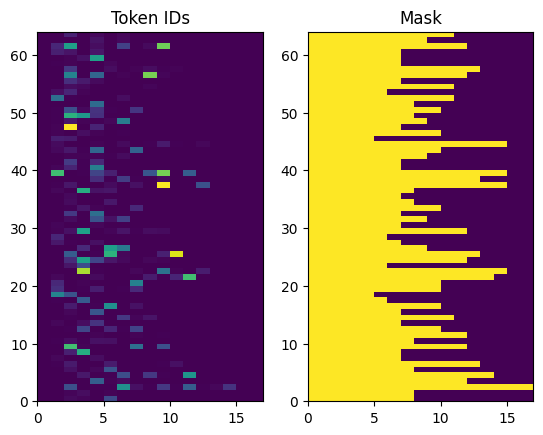

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [20]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [21]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2  32  28 365  16 434   8  11 505   6]

[  2  32 215  10 505  25  47 218 580   4]
[ 32 215  10 505  25  47 218 580   4   3]


## The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word. 

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [22]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [23]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [24]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 18)
Encoder output, shape (batch, s, units): (64, 18, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [25]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 18, 256)
Target sequence, shape (batch, t, units): (64, 16, 256)
Attention result, shape (batch, t, units): (64, 16, 256)
Attention weights, shape (batch, t, s):    (64, 16, 18)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [27]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.9999999 , 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

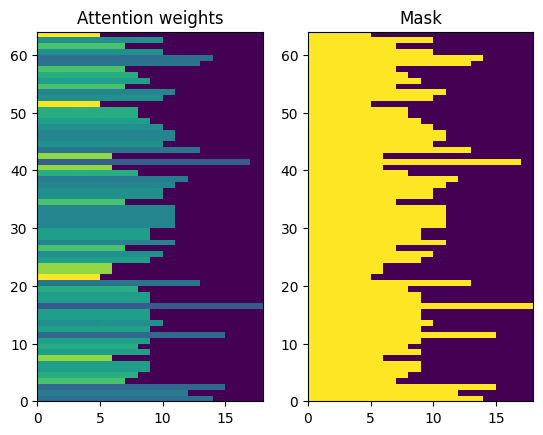

In [28]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [29]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [30]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [31]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token. 

In [32]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 18, 256)
input target tokens shape: (batch, t) (64, 16)
logits shape shape: (batch, target_vocabulary_size) (64, 16, 5000)


#### Inference

To use it for inference you'll need a couple more methods:

In [33]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [34]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [35]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [36]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'relationship valid neighbor rat richer deposited cafe remarkable hid apology',
       b'trains begun crime quickly stressful physics vanished test wished decisions',
       b'shampoo notice dish products lid ashamed picnic failed stone criminals'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [37]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [38]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 18)
Target tokens, shape: (batch, t) (64, 16)
logits, shape: (batch, t, target_vocabulary_size) (64, 16, 5000)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [39]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [40]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [41]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [42]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

That should roughly match the values returned by running a few steps of evaluation:

In [43]:
model.evaluate(val_ds, steps=20, return_dict=True)

 1/20 [>.............................] - ETA: 1:58 - loss: 8.5118 - masked_acc: 0.0000e+00 - masked_loss: 8.5118

 3/20 [===>..........................] - ETA: 0s - loss: 8.5107 - masked_acc: 0.0000e+00 - masked_loss: 8.5107  

 6/20 [========>.....................] - ETA: 0s - loss: 8.5102 - masked_acc: 6.0606e-04 - masked_loss: 8.5102

 9/20 [============>.................] - ETA: 0s - loss: 8.5101 - masked_acc: 4.0404e-04 - masked_loss: 8.5101

12/20 [=================>............] - ETA: 0s - loss: 8.5112 - masked_acc: 3.0303e-04 - masked_loss: 8.5112

15/20 [=====================>........] - ETA: 0s - loss: 8.5108 - masked_acc: 2.4242e-04 - masked_loss: 8.5108

18/20 [==========================>...] - ETA: 0s - loss: 8.5098 - masked_acc: 2.0202e-04 - masked_loss: 8.5098

20/20 [==============================] - 7s 22ms/step - loss: 8.5103 - masked_acc: 2.7872e-04 - masked_loss: 8.5103


{'loss': 8.510286331176758,
 'masked_acc': 0.0002787174307741225,
 'masked_loss': 8.510286331176758}

In [44]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2023-12-07 12:22:47.016525: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_35/output/_22'


I0000 00:00:1701951767.593696   17028 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/100 [..............................] - ETA: 19:12 - loss: 8.5148 - masked_acc: 0.0000e+00 - masked_loss: 8.5148

  2/100 [..............................] - ETA: 12s - loss: 8.4231 - masked_acc: 0.0772 - masked_loss: 8.4231      

  3/100 [..............................] - ETA: 12s - loss: 8.3118 - masked_acc: 0.0967 - masked_loss: 8.3118

  4/100 [>.............................] - ETA: 12s - loss: 8.1668 - masked_acc: 0.1055 - masked_loss: 8.1668

  5/100 [>.............................] - ETA: 12s - loss: 7.9955 - masked_acc: 0.1128 - masked_loss: 7.9955

  6/100 [>.............................] - ETA: 11s - loss: 7.8253 - masked_acc: 0.1203 - masked_loss: 7.8253

  7/100 [=>............................] - ETA: 11s - loss: 7.6636 - masked_acc: 0.1227 - masked_loss: 7.6636

  8/100 [=>............................] - ETA: 11s - loss: 7.5092 - masked_acc: 0.1224 - masked_loss: 7.5092

  9/100 [=>............................] - ETA: 11s - loss: 7.3641 - masked_acc: 0.1223 - masked_loss: 7.3641

 10/100 [==>...........................] - ETA: 11s - loss: 7.2311 - masked_acc: 0.1214 - masked_loss: 7.2311

 11/100 [==>...........................] - ETA: 11s - loss: 7.1023 - masked_acc: 0.1220 - masked_loss: 7.1023

 12/100 [==>...........................] - ETA: 11s - loss: 6.9795 - masked_acc: 0.1220 - masked_loss: 6.9795

 13/100 [==>...........................] - ETA: 11s - loss: 6.8759 - masked_acc: 0.1221 - masked_loss: 6.8759

 14/100 [===>..........................] - ETA: 10s - loss: 6.7798 - masked_acc: 0.1224 - masked_loss: 6.7798

 15/100 [===>..........................] - ETA: 10s - loss: 6.6972 - masked_acc: 0.1223 - masked_loss: 6.6972

 16/100 [===>..........................] - ETA: 10s - loss: 6.6311 - masked_acc: 0.1220 - masked_loss: 6.6311

 17/100 [====>.........................] - ETA: 10s - loss: 6.5618 - masked_acc: 0.1239 - masked_loss: 6.5618

 18/100 [====>.........................] - ETA: 10s - loss: 6.4998 - masked_acc: 0.1275 - masked_loss: 6.4998

 19/100 [====>.........................] - ETA: 10s - loss: 6.4462 - masked_acc: 0.1317 - masked_loss: 6.4462

 20/100 [=====>........................] - ETA: 10s - loss: 6.3972 - masked_acc: 0.1362 - masked_loss: 6.3972

 21/100 [=====>........................] - ETA: 10s - loss: 6.3602 - masked_acc: 0.1387 - masked_loss: 6.3602

 22/100 [=====>........................] - ETA: 9s - loss: 6.3152 - masked_acc: 0.1422 - masked_loss: 6.3152 

 23/100 [=====>........................] - ETA: 9s - loss: 6.2758 - masked_acc: 0.1452 - masked_loss: 6.2758

 25/100 [======>.......................] - ETA: 9s - loss: 6.2029 - masked_acc: 0.1470 - masked_loss: 6.2029

 27/100 [=======>......................] - ETA: 8s - loss: 6.1388 - masked_acc: 0.1495 - masked_loss: 6.1388

 29/100 [=======>......................] - ETA: 8s - loss: 6.0810 - masked_acc: 0.1523 - masked_loss: 6.0810

 30/100 [========>.....................] - ETA: 8s - loss: 6.0541 - masked_acc: 0.1542 - masked_loss: 6.0541

 31/100 [========>.....................] - ETA: 8s - loss: 6.0291 - masked_acc: 0.1556 - masked_loss: 6.0291

 32/100 [========>.....................] - ETA: 8s - loss: 6.0088 - masked_acc: 0.1568 - masked_loss: 6.0088

 33/100 [========>.....................] - ETA: 7s - loss: 5.9837 - masked_acc: 0.1592 - masked_loss: 5.9837

 34/100 [=========>....................] - ETA: 7s - loss: 5.9606 - masked_acc: 0.1613 - masked_loss: 5.9606

 36/100 [=========>....................] - ETA: 7s - loss: 5.9208 - masked_acc: 0.1645 - masked_loss: 5.9208

 38/100 [==========>...................] - ETA: 6s - loss: 5.8790 - masked_acc: 0.1691 - masked_loss: 5.8790

 40/100 [===========>..................] - ETA: 6s - loss: 5.8375 - masked_acc: 0.1723 - masked_loss: 5.8375

 42/100 [===========>..................] - ETA: 6s - loss: 5.7955 - masked_acc: 0.1760 - masked_loss: 5.7955

 43/100 [===========>..................] - ETA: 6s - loss: 5.7798 - masked_acc: 0.1780 - masked_loss: 5.7798

 44/100 [============>.................] - ETA: 6s - loss: 5.7620 - masked_acc: 0.1796 - masked_loss: 5.7620

 46/100 [============>.................] - ETA: 5s - loss: 5.7203 - masked_acc: 0.1832 - masked_loss: 5.7203

 47/100 [=============>................] - ETA: 5s - loss: 5.7049 - masked_acc: 0.1849 - masked_loss: 5.7049

 49/100 [=============>................] - ETA: 5s - loss: 5.6668 - masked_acc: 0.1893 - masked_loss: 5.6668

 50/100 [==============>...............] - ETA: 5s - loss: 5.6465 - masked_acc: 0.1910 - masked_loss: 5.6465

 52/100 [==============>...............] - ETA: 4s - loss: 5.6107 - masked_acc: 0.1941 - masked_loss: 5.6107

 54/100 [===============>..............] - ETA: 4s - loss: 5.5767 - masked_acc: 0.1975 - masked_loss: 5.5767

 56/100 [===============>..............] - ETA: 4s - loss: 5.5442 - masked_acc: 0.2008 - masked_loss: 5.5442

 57/100 [================>.............] - ETA: 4s - loss: 5.5285 - masked_acc: 0.2026 - masked_loss: 5.5285

 58/100 [================>.............] - ETA: 4s - loss: 5.5094 - masked_acc: 0.2046 - masked_loss: 5.5094

 59/100 [================>.............] - ETA: 4s - loss: 5.4979 - masked_acc: 0.2057 - masked_loss: 5.4979

 60/100 [=================>............] - ETA: 4s - loss: 5.4834 - masked_acc: 0.2074 - masked_loss: 5.4834

 62/100 [=================>............] - ETA: 3s - loss: 5.4537 - masked_acc: 0.2105 - masked_loss: 5.4537

 64/100 [==================>...........] - ETA: 3s - loss: 5.4267 - masked_acc: 0.2133 - masked_loss: 5.4267

 66/100 [==================>...........] - ETA: 3s - loss: 5.3994 - masked_acc: 0.2157 - masked_loss: 5.3994

 67/100 [===================>..........] - ETA: 3s - loss: 5.3865 - masked_acc: 0.2172 - masked_loss: 5.3865

 68/100 [===================>..........] - ETA: 3s - loss: 5.3735 - masked_acc: 0.2185 - masked_loss: 5.3735

 70/100 [====================>.........] - ETA: 2s - loss: 5.3454 - masked_acc: 0.2216 - masked_loss: 5.3454

 72/100 [====================>.........] - ETA: 2s - loss: 5.3202 - masked_acc: 0.2242 - masked_loss: 5.3202

 74/100 [=====================>........] - ETA: 2s - loss: 5.2998 - masked_acc: 0.2265 - masked_loss: 5.2998

 75/100 [=====================>........] - ETA: 2s - loss: 5.2888 - masked_acc: 0.2281 - masked_loss: 5.2888

 77/100 [======================>.......] - ETA: 2s - loss: 5.2651 - masked_acc: 0.2309 - masked_loss: 5.2651

 79/100 [======================>.......] - ETA: 1s - loss: 5.2406 - masked_acc: 0.2333 - masked_loss: 5.2406

 80/100 [=======================>......] - ETA: 1s - loss: 5.2312 - masked_acc: 0.2343 - masked_loss: 5.2312

 82/100 [=======================>......] - ETA: 1s - loss: 5.2114 - masked_acc: 0.2367 - masked_loss: 5.2114

 84/100 [========================>.....] - ETA: 1s - loss: 5.1922 - masked_acc: 0.2385 - masked_loss: 5.1922

 86/100 [========================>.....] - ETA: 1s - loss: 5.1703 - masked_acc: 0.2409 - masked_loss: 5.1703

 88/100 [=========================>....] - ETA: 1s - loss: 5.1506 - masked_acc: 0.2432 - masked_loss: 5.1506

 90/100 [==========================>...] - ETA: 0s - loss: 5.1307 - masked_acc: 0.2454 - masked_loss: 5.1307

 92/100 [==========================>...] - ETA: 0s - loss: 5.1100 - masked_acc: 0.2476 - masked_loss: 5.1100

 94/100 [===========================>..] - ETA: 0s - loss: 5.0903 - masked_acc: 0.2499 - masked_loss: 5.0903

 96/100 [===========================>..] - ETA: 0s - loss: 5.0715 - masked_acc: 0.2522 - masked_loss: 5.0715

 98/100 [============================>.] - ETA: 0s - loss: 5.0539 - masked_acc: 0.2545 - masked_loss: 5.0539

100/100 [==============================] - ETA: 0s - loss: 5.0340 - masked_acc: 0.2569 - masked_loss: 5.0340

100/100 [==============================] - 20s 84ms/step - loss: 5.0340 - masked_acc: 0.2569 - masked_loss: 5.0340 - val_loss: 4.1026 - val_masked_acc: 0.3588 - val_masked_loss: 4.1026


Epoch 2/100


  1/100 [..............................] - ETA: 14s - loss: 3.8557 - masked_acc: 0.3762 - masked_loss: 3.8557

  2/100 [..............................] - ETA: 11s - loss: 4.0827 - masked_acc: 0.3545 - masked_loss: 4.0827

  3/100 [..............................] - ETA: 11s - loss: 4.1665 - masked_acc: 0.3528 - masked_loss: 4.1665

  5/100 [>.............................] - ETA: 7s - loss: 4.1454 - masked_acc: 0.3484 - masked_loss: 4.1454 

  7/100 [=>............................] - ETA: 5s - loss: 4.1111 - masked_acc: 0.3552 - masked_loss: 4.1111

  8/100 [=>............................] - ETA: 6s - loss: 4.0791 - masked_acc: 0.3601 - masked_loss: 4.0791

  9/100 [=>............................] - ETA: 6s - loss: 4.0838 - masked_acc: 0.3592 - masked_loss: 4.0838

 11/100 [==>...........................] - ETA: 6s - loss: 4.1136 - masked_acc: 0.3585 - masked_loss: 4.1136

 13/100 [==>...........................] - ETA: 5s - loss: 4.1016 - masked_acc: 0.3601 - masked_loss: 4.1016

 15/100 [===>..........................] - ETA: 5s - loss: 4.0863 - masked_acc: 0.3631 - masked_loss: 4.0863

 17/100 [====>.........................] - ETA: 5s - loss: 4.0663 - masked_acc: 0.3629 - masked_loss: 4.0663

 19/100 [====>.........................] - ETA: 4s - loss: 4.0531 - masked_acc: 0.3623 - masked_loss: 4.0531

 21/100 [=====>........................] - ETA: 4s - loss: 4.0389 - masked_acc: 0.3645 - masked_loss: 4.0389

 22/100 [=====>........................] - ETA: 4s - loss: 4.0376 - masked_acc: 0.3650 - masked_loss: 4.0376

 23/100 [=====>........................] - ETA: 4s - loss: 4.0196 - masked_acc: 0.3666 - masked_loss: 4.0196

 25/100 [======>.......................] - ETA: 4s - loss: 4.0054 - masked_acc: 0.3690 - masked_loss: 4.0054

 27/100 [=======>......................] - ETA: 4s - loss: 3.9925 - masked_acc: 0.3709 - masked_loss: 3.9925

 29/100 [=======>......................] - ETA: 4s - loss: 3.9891 - masked_acc: 0.3715 - masked_loss: 3.9891

 31/100 [========>.....................] - ETA: 3s - loss: 3.9766 - masked_acc: 0.3730 - masked_loss: 3.9766

 33/100 [========>.....................] - ETA: 3s - loss: 3.9684 - masked_acc: 0.3731 - masked_loss: 3.9684

 34/100 [=========>....................] - ETA: 3s - loss: 3.9669 - masked_acc: 0.3731 - masked_loss: 3.9669

 36/100 [=========>....................] - ETA: 3s - loss: 3.9539 - masked_acc: 0.3745 - masked_loss: 3.9539

 37/100 [==========>...................] - ETA: 3s - loss: 3.9516 - masked_acc: 0.3752 - masked_loss: 3.9516

 39/100 [==========>...................] - ETA: 3s - loss: 3.9488 - masked_acc: 0.3758 - masked_loss: 3.9488

 41/100 [===========>..................] - ETA: 3s - loss: 3.9404 - masked_acc: 0.3772 - masked_loss: 3.9404

 43/100 [===========>..................] - ETA: 3s - loss: 3.9290 - masked_acc: 0.3783 - masked_loss: 3.9290

 45/100 [============>.................] - ETA: 2s - loss: 3.9190 - masked_acc: 0.3794 - masked_loss: 3.9190

 47/100 [=============>................] - ETA: 2s - loss: 3.9083 - masked_acc: 0.3806 - masked_loss: 3.9083

 48/100 [=============>................] - ETA: 2s - loss: 3.9088 - masked_acc: 0.3802 - masked_loss: 3.9088

 50/100 [==============>...............] - ETA: 2s - loss: 3.9029 - masked_acc: 0.3805 - masked_loss: 3.9029

 52/100 [==============>...............] - ETA: 2s - loss: 3.8873 - masked_acc: 0.3820 - masked_loss: 3.8873

 54/100 [===============>..............] - ETA: 2s - loss: 3.8807 - masked_acc: 0.3823 - masked_loss: 3.8807

 56/100 [===============>..............] - ETA: 2s - loss: 3.8689 - masked_acc: 0.3842 - masked_loss: 3.8689

 57/100 [================>.............] - ETA: 2s - loss: 3.8616 - masked_acc: 0.3850 - masked_loss: 3.8616

 59/100 [================>.............] - ETA: 2s - loss: 3.8538 - masked_acc: 0.3856 - masked_loss: 3.8538

 61/100 [=================>............] - ETA: 2s - loss: 3.8484 - masked_acc: 0.3863 - masked_loss: 3.8484

 63/100 [=================>............] - ETA: 1s - loss: 3.8435 - masked_acc: 0.3870 - masked_loss: 3.8435

 65/100 [==================>...........] - ETA: 1s - loss: 3.8406 - masked_acc: 0.3880 - masked_loss: 3.8406

 67/100 [===================>..........] - ETA: 1s - loss: 3.8322 - masked_acc: 0.3887 - masked_loss: 3.8322

 68/100 [===================>..........] - ETA: 1s - loss: 3.8285 - masked_acc: 0.3884 - masked_loss: 3.8285

 70/100 [====================>.........] - ETA: 1s - loss: 3.8189 - masked_acc: 0.3895 - masked_loss: 3.8189

 71/100 [====================>.........] - ETA: 1s - loss: 3.8132 - masked_acc: 0.3901 - masked_loss: 3.8132

 73/100 [====================>.........] - ETA: 1s - loss: 3.8082 - masked_acc: 0.3908 - masked_loss: 3.8082

 75/100 [=====================>........] - ETA: 1s - loss: 3.8044 - masked_acc: 0.3911 - masked_loss: 3.8044

 77/100 [======================>.......] - ETA: 1s - loss: 3.7993 - masked_acc: 0.3917 - masked_loss: 3.7993

 79/100 [======================>.......] - ETA: 1s - loss: 3.7925 - masked_acc: 0.3922 - masked_loss: 3.7925

 81/100 [=======================>......] - ETA: 0s - loss: 3.7864 - masked_acc: 0.3924 - masked_loss: 3.7864

 82/100 [=======================>......] - ETA: 0s - loss: 3.7841 - masked_acc: 0.3926 - masked_loss: 3.7841

 84/100 [========================>.....] - ETA: 0s - loss: 3.7763 - masked_acc: 0.3939 - masked_loss: 3.7763

 86/100 [========================>.....] - ETA: 0s - loss: 3.7709 - masked_acc: 0.3946 - masked_loss: 3.7709

 88/100 [=========================>....] - ETA: 0s - loss: 3.7651 - masked_acc: 0.3954 - masked_loss: 3.7651

 90/100 [==========================>...] - ETA: 0s - loss: 3.7601 - masked_acc: 0.3964 - masked_loss: 3.7601

 92/100 [==========================>...] - ETA: 0s - loss: 3.7511 - masked_acc: 0.3974 - masked_loss: 3.7511

 94/100 [===========================>..] - ETA: 0s - loss: 3.7431 - masked_acc: 0.3988 - masked_loss: 3.7431

 96/100 [===========================>..] - ETA: 0s - loss: 3.7353 - masked_acc: 0.3997 - masked_loss: 3.7353

 97/100 [============================>.] - ETA: 0s - loss: 3.7304 - masked_acc: 0.4004 - masked_loss: 3.7304

 99/100 [============================>.] - ETA: 0s - loss: 3.7236 - masked_acc: 0.4013 - masked_loss: 3.7236

100/100 [==============================] - 5s 50ms/step - loss: 3.7212 - masked_acc: 0.4018 - masked_loss: 3.7212 - val_loss: 3.3733 - val_masked_acc: 0.4407 - val_masked_loss: 3.3733


Epoch 3/100


  1/100 [..............................] - ETA: 2s - loss: 3.4623 - masked_acc: 0.4246 - masked_loss: 3.4623

  3/100 [..............................] - ETA: 2s - loss: 3.4374 - masked_acc: 0.4304 - masked_loss: 3.4374

  5/100 [>.............................] - ETA: 2s - loss: 3.4582 - masked_acc: 0.4242 - masked_loss: 3.4582

  7/100 [=>............................] - ETA: 2s - loss: 3.4499 - masked_acc: 0.4298 - masked_loss: 3.4499

  9/100 [=>............................] - ETA: 2s - loss: 3.4408 - masked_acc: 0.4319 - masked_loss: 3.4408

 11/100 [==>...........................] - ETA: 2s - loss: 3.4071 - masked_acc: 0.4385 - masked_loss: 3.4071

 13/100 [==>...........................] - ETA: 2s - loss: 3.3839 - masked_acc: 0.4409 - masked_loss: 3.3839

 15/100 [===>..........................] - ETA: 2s - loss: 3.3710 - masked_acc: 0.4409 - masked_loss: 3.3710

 17/100 [====>.........................] - ETA: 2s - loss: 3.3582 - masked_acc: 0.4437 - masked_loss: 3.3582

 19/100 [====>.........................] - ETA: 2s - loss: 3.3451 - masked_acc: 0.4466 - masked_loss: 3.3451

 21/100 [=====>........................] - ETA: 2s - loss: 3.3468 - masked_acc: 0.4470 - masked_loss: 3.3468

 23/100 [=====>........................] - ETA: 2s - loss: 3.3415 - masked_acc: 0.4492 - masked_loss: 3.3415

 25/100 [======>.......................] - ETA: 1s - loss: 3.3360 - masked_acc: 0.4485 - masked_loss: 3.3360

 27/100 [=======>......................] - ETA: 1s - loss: 3.3302 - masked_acc: 0.4503 - masked_loss: 3.3302

 29/100 [=======>......................] - ETA: 2s - loss: 3.3250 - masked_acc: 0.4515 - masked_loss: 3.3250

 31/100 [========>.....................] - ETA: 2s - loss: 3.3208 - masked_acc: 0.4522 - masked_loss: 3.3208

 33/100 [========>.....................] - ETA: 1s - loss: 3.3117 - masked_acc: 0.4536 - masked_loss: 3.3117

 35/100 [=========>....................] - ETA: 1s - loss: 3.3045 - masked_acc: 0.4547 - masked_loss: 3.3045

 37/100 [==========>...................] - ETA: 1s - loss: 3.2921 - masked_acc: 0.4563 - masked_loss: 3.2921

 39/100 [==========>...................] - ETA: 1s - loss: 3.2830 - masked_acc: 0.4577 - masked_loss: 3.2830

 42/100 [===========>..................] - ETA: 1s - loss: 3.2746 - masked_acc: 0.4590 - masked_loss: 3.2746

 44/100 [============>.................] - ETA: 1s - loss: 3.2710 - masked_acc: 0.4591 - masked_loss: 3.2710

 46/100 [============>.................] - ETA: 1s - loss: 3.2644 - masked_acc: 0.4607 - masked_loss: 3.2644

 48/100 [=============>................] - ETA: 1s - loss: 3.2651 - masked_acc: 0.4612 - masked_loss: 3.2651

 50/100 [==============>...............] - ETA: 1s - loss: 3.2495 - masked_acc: 0.4635 - masked_loss: 3.2495

 52/100 [==============>...............] - ETA: 1s - loss: 3.2411 - masked_acc: 0.4640 - masked_loss: 3.2411

 54/100 [===============>..............] - ETA: 1s - loss: 3.2361 - masked_acc: 0.4650 - masked_loss: 3.2361

 56/100 [===============>..............] - ETA: 1s - loss: 3.2271 - masked_acc: 0.4662 - masked_loss: 3.2271

 58/100 [================>.............] - ETA: 1s - loss: 3.2223 - masked_acc: 0.4668 - masked_loss: 3.2223

 60/100 [=================>............] - ETA: 1s - loss: 3.2167 - masked_acc: 0.4678 - masked_loss: 3.2167

 62/100 [=================>............] - ETA: 1s - loss: 3.2106 - masked_acc: 0.4689 - masked_loss: 3.2106

 64/100 [==================>...........] - ETA: 1s - loss: 3.2078 - masked_acc: 0.4699 - masked_loss: 3.2078

 66/100 [==================>...........] - ETA: 0s - loss: 3.2074 - masked_acc: 0.4699 - masked_loss: 3.2074

 68/100 [===================>..........] - ETA: 0s - loss: 3.2002 - masked_acc: 0.4708 - masked_loss: 3.2002

 70/100 [====================>.........] - ETA: 0s - loss: 3.1973 - masked_acc: 0.4705 - masked_loss: 3.1973

 72/100 [====================>.........] - ETA: 0s - loss: 3.1928 - masked_acc: 0.4719 - masked_loss: 3.1928

 74/100 [=====================>........] - ETA: 0s - loss: 3.1848 - masked_acc: 0.4729 - masked_loss: 3.1848

 76/100 [=====================>........] - ETA: 0s - loss: 3.1802 - masked_acc: 0.4736 - masked_loss: 3.1802

 78/100 [======================>.......] - ETA: 0s - loss: 3.1741 - masked_acc: 0.4746 - masked_loss: 3.1741

 81/100 [=======================>......] - ETA: 0s - loss: 3.1679 - masked_acc: 0.4752 - masked_loss: 3.1679

 82/100 [=======================>......] - ETA: 0s - loss: 3.1679 - masked_acc: 0.4751 - masked_loss: 3.1679

 84/100 [========================>.....] - ETA: 0s - loss: 3.1610 - masked_acc: 0.4757 - masked_loss: 3.1610

 86/100 [========================>.....] - ETA: 0s - loss: 3.1554 - masked_acc: 0.4763 - masked_loss: 3.1554

 88/100 [=========================>....] - ETA: 0s - loss: 3.1502 - masked_acc: 0.4770 - masked_loss: 3.1502

 89/100 [=========================>....] - ETA: 0s - loss: 3.1517 - masked_acc: 0.4767 - masked_loss: 3.1517

 91/100 [==========================>...] - ETA: 0s - loss: 3.1463 - masked_acc: 0.4773 - masked_loss: 3.1463

 93/100 [==========================>...] - ETA: 0s - loss: 3.1430 - masked_acc: 0.4778 - masked_loss: 3.1430

 95/100 [===========================>..] - ETA: 0s - loss: 3.1376 - masked_acc: 0.4785 - masked_loss: 3.1376

 97/100 [============================>.] - ETA: 0s - loss: 3.1297 - masked_acc: 0.4796 - masked_loss: 3.1297

 99/100 [============================>.] - ETA: 0s - loss: 3.1231 - masked_acc: 0.4802 - masked_loss: 3.1231

100/100 [==============================] - 4s 36ms/step - loss: 3.1184 - masked_acc: 0.4806 - masked_loss: 3.1184 - val_loss: 2.8760 - val_masked_acc: 0.5082 - val_masked_loss: 2.8760


Epoch 4/100


  1/100 [..............................] - ETA: 2s - loss: 2.8154 - masked_acc: 0.5278 - masked_loss: 2.8154

  3/100 [..............................] - ETA: 2s - loss: 2.8014 - masked_acc: 0.5255 - masked_loss: 2.8014

  5/100 [>.............................] - ETA: 2s - loss: 2.8545 - masked_acc: 0.5162 - masked_loss: 2.8545

  7/100 [=>............................] - ETA: 2s - loss: 2.8479 - masked_acc: 0.5106 - masked_loss: 2.8479

  9/100 [=>............................] - ETA: 2s - loss: 2.8703 - masked_acc: 0.5097 - masked_loss: 2.8703

 10/100 [==>...........................] - ETA: 3s - loss: 2.8922 - masked_acc: 0.5087 - masked_loss: 2.8922

 12/100 [==>...........................] - ETA: 3s - loss: 2.8830 - masked_acc: 0.5107 - masked_loss: 2.8830

 14/100 [===>..........................] - ETA: 2s - loss: 2.8758 - masked_acc: 0.5132 - masked_loss: 2.8758

 16/100 [===>..........................] - ETA: 2s - loss: 2.8765 - masked_acc: 0.5121 - masked_loss: 2.8765

 18/100 [====>.........................] - ETA: 2s - loss: 2.8605 - masked_acc: 0.5150 - masked_loss: 2.8605

 20/100 [=====>........................] - ETA: 2s - loss: 2.8472 - masked_acc: 0.5172 - masked_loss: 2.8472

 22/100 [=====>........................] - ETA: 2s - loss: 2.8409 - masked_acc: 0.5175 - masked_loss: 2.8409

 24/100 [======>.......................] - ETA: 2s - loss: 2.8434 - masked_acc: 0.5169 - masked_loss: 2.8434

 26/100 [======>.......................] - ETA: 2s - loss: 2.8500 - masked_acc: 0.5176 - masked_loss: 2.8500

 28/100 [=======>......................] - ETA: 2s - loss: 2.8296 - masked_acc: 0.5204 - masked_loss: 2.8296

 30/100 [========>.....................] - ETA: 2s - loss: 2.8266 - masked_acc: 0.5215 - masked_loss: 2.8266

 32/100 [========>.....................] - ETA: 2s - loss: 2.8138 - masked_acc: 0.5237 - masked_loss: 2.8138

 34/100 [=========>....................] - ETA: 1s - loss: 2.8193 - masked_acc: 0.5234 - masked_loss: 2.8193

 36/100 [=========>....................] - ETA: 1s - loss: 2.8136 - masked_acc: 0.5239 - masked_loss: 2.8136

 38/100 [==========>...................] - ETA: 1s - loss: 2.8027 - masked_acc: 0.5254 - masked_loss: 2.8027

 40/100 [===========>..................] - ETA: 1s - loss: 2.7892 - masked_acc: 0.5275 - masked_loss: 2.7892

 42/100 [===========>..................] - ETA: 1s - loss: 2.7856 - masked_acc: 0.5279 - masked_loss: 2.7856

 44/100 [============>.................] - ETA: 1s - loss: 2.7842 - masked_acc: 0.5284 - masked_loss: 2.7842

 46/100 [============>.................] - ETA: 1s - loss: 2.7812 - masked_acc: 0.5282 - masked_loss: 2.7812

 48/100 [=============>................] - ETA: 1s - loss: 2.7784 - masked_acc: 0.5283 - masked_loss: 2.7784

 50/100 [==============>...............] - ETA: 1s - loss: 2.7710 - masked_acc: 0.5287 - masked_loss: 2.7710

 52/100 [==============>...............] - ETA: 1s - loss: 2.7710 - masked_acc: 0.5287 - masked_loss: 2.7710

 54/100 [===============>..............] - ETA: 1s - loss: 2.7618 - masked_acc: 0.5297 - masked_loss: 2.7618

 56/100 [===============>..............] - ETA: 1s - loss: 2.7625 - masked_acc: 0.5302 - masked_loss: 2.7625

 58/100 [================>.............] - ETA: 1s - loss: 2.7617 - masked_acc: 0.5307 - masked_loss: 2.7617

 60/100 [=================>............] - ETA: 1s - loss: 2.7638 - masked_acc: 0.5304 - masked_loss: 2.7638

 62/100 [=================>............] - ETA: 1s - loss: 2.7610 - masked_acc: 0.5301 - masked_loss: 2.7610

 65/100 [==================>...........] - ETA: 0s - loss: 2.7611 - masked_acc: 0.5305 - masked_loss: 2.7611

 67/100 [===================>..........] - ETA: 0s - loss: 2.7547 - masked_acc: 0.5317 - masked_loss: 2.7547

 69/100 [===================>..........] - ETA: 0s - loss: 2.7541 - masked_acc: 0.5317 - masked_loss: 2.7541

 71/100 [====================>.........] - ETA: 0s - loss: 2.7497 - masked_acc: 0.5323 - masked_loss: 2.7497

 73/100 [====================>.........] - ETA: 0s - loss: 2.7448 - masked_acc: 0.5331 - masked_loss: 2.7448

 75/100 [=====================>........] - ETA: 0s - loss: 2.7433 - masked_acc: 0.5330 - masked_loss: 2.7433

 77/100 [======================>.......] - ETA: 0s - loss: 2.7402 - masked_acc: 0.5334 - masked_loss: 2.7402

 79/100 [======================>.......] - ETA: 0s - loss: 2.7323 - masked_acc: 0.5346 - masked_loss: 2.7323

 80/100 [=======================>......] - ETA: 0s - loss: 2.7351 - masked_acc: 0.5343 - masked_loss: 2.7351

 82/100 [=======================>......] - ETA: 0s - loss: 2.7354 - masked_acc: 0.5346 - masked_loss: 2.7354

 84/100 [========================>.....] - ETA: 0s - loss: 2.7321 - masked_acc: 0.5349 - masked_loss: 2.7321

 86/100 [========================>.....] - ETA: 0s - loss: 2.7265 - masked_acc: 0.5361 - masked_loss: 2.7265

 88/100 [=========================>....] - ETA: 0s - loss: 2.7265 - masked_acc: 0.5358 - masked_loss: 2.7265

 90/100 [==========================>...] - ETA: 0s - loss: 2.7212 - masked_acc: 0.5364 - masked_loss: 2.7212

 92/100 [==========================>...] - ETA: 0s - loss: 2.7162 - masked_acc: 0.5368 - masked_loss: 2.7162

 94/100 [===========================>..] - ETA: 0s - loss: 2.7132 - masked_acc: 0.5373 - masked_loss: 2.7132

 96/100 [===========================>..] - ETA: 0s - loss: 2.7108 - masked_acc: 0.5379 - masked_loss: 2.7108

 97/100 [============================>.] - ETA: 0s - loss: 2.7060 - masked_acc: 0.5385 - masked_loss: 2.7060

 99/100 [============================>.] - ETA: 0s - loss: 2.7027 - masked_acc: 0.5390 - masked_loss: 2.7027

100/100 [==============================] - 3s 34ms/step - loss: 2.7033 - masked_acc: 0.5391 - masked_loss: 2.7033 - val_loss: 2.5197 - val_masked_acc: 0.5584 - val_masked_loss: 2.5197


Epoch 5/100


  1/100 [..............................] - ETA: 2s - loss: 2.8048 - masked_acc: 0.5404 - masked_loss: 2.8048

  3/100 [..............................] - ETA: 2s - loss: 2.6505 - masked_acc: 0.5535 - masked_loss: 2.6505

  5/100 [>.............................] - ETA: 2s - loss: 2.5950 - masked_acc: 0.5546 - masked_loss: 2.5950

  7/100 [=>............................] - ETA: 2s - loss: 2.6161 - masked_acc: 0.5486 - masked_loss: 2.6161

  9/100 [=>............................] - ETA: 2s - loss: 2.6230 - masked_acc: 0.5468 - masked_loss: 2.6230

 11/100 [==>...........................] - ETA: 2s - loss: 2.5927 - masked_acc: 0.5505 - masked_loss: 2.5927

 13/100 [==>...........................] - ETA: 3s - loss: 2.6154 - masked_acc: 0.5491 - masked_loss: 2.6154

 15/100 [===>..........................] - ETA: 2s - loss: 2.6009 - masked_acc: 0.5489 - masked_loss: 2.6009

 17/100 [====>.........................] - ETA: 2s - loss: 2.6129 - masked_acc: 0.5473 - masked_loss: 2.6129

 19/100 [====>.........................] - ETA: 2s - loss: 2.6104 - masked_acc: 0.5473 - masked_loss: 2.6104

 21/100 [=====>........................] - ETA: 2s - loss: 2.6045 - masked_acc: 0.5496 - masked_loss: 2.6045

 23/100 [=====>........................] - ETA: 2s - loss: 2.5986 - masked_acc: 0.5504 - masked_loss: 2.5986

 25/100 [======>.......................] - ETA: 2s - loss: 2.5824 - masked_acc: 0.5535 - masked_loss: 2.5824

 27/100 [=======>......................] - ETA: 2s - loss: 2.5737 - masked_acc: 0.5550 - masked_loss: 2.5737

 29/100 [=======>......................] - ETA: 2s - loss: 2.5652 - masked_acc: 0.5556 - masked_loss: 2.5652

 31/100 [========>.....................] - ETA: 2s - loss: 2.5622 - masked_acc: 0.5562 - masked_loss: 2.5622

 33/100 [========>.....................] - ETA: 2s - loss: 2.5568 - masked_acc: 0.5566 - masked_loss: 2.5568

 35/100 [=========>....................] - ETA: 2s - loss: 2.5600 - masked_acc: 0.5563 - masked_loss: 2.5600

 37/100 [==========>...................] - ETA: 2s - loss: 2.5574 - masked_acc: 0.5567 - masked_loss: 2.5574

 39/100 [==========>...................] - ETA: 1s - loss: 2.5547 - masked_acc: 0.5564 - masked_loss: 2.5547

 41/100 [===========>..................] - ETA: 1s - loss: 2.5560 - masked_acc: 0.5564 - masked_loss: 2.5560

 43/100 [===========>..................] - ETA: 1s - loss: 2.5533 - masked_acc: 0.5565 - masked_loss: 2.5533

 44/100 [============>.................] - ETA: 1s - loss: 2.5518 - masked_acc: 0.5568 - masked_loss: 2.5518

 46/100 [============>.................] - ETA: 1s - loss: 2.5444 - masked_acc: 0.5581 - masked_loss: 2.5444

 48/100 [=============>................] - ETA: 1s - loss: 2.5399 - masked_acc: 0.5582 - masked_loss: 2.5399

 50/100 [==============>...............] - ETA: 1s - loss: 2.5283 - masked_acc: 0.5598 - masked_loss: 2.5283

 52/100 [==============>...............] - ETA: 1s - loss: 2.5206 - masked_acc: 0.5607 - masked_loss: 2.5206

 54/100 [===============>..............] - ETA: 1s - loss: 2.5165 - masked_acc: 0.5612 - masked_loss: 2.5165

 56/100 [===============>..............] - ETA: 1s - loss: 2.5184 - masked_acc: 0.5612 - masked_loss: 2.5184

 58/100 [================>.............] - ETA: 1s - loss: 2.5109 - masked_acc: 0.5616 - masked_loss: 2.5109

 60/100 [=================>............] - ETA: 1s - loss: 2.5087 - masked_acc: 0.5619 - masked_loss: 2.5087

 62/100 [=================>............] - ETA: 1s - loss: 2.5040 - masked_acc: 0.5627 - masked_loss: 2.5040

 64/100 [==================>...........] - ETA: 1s - loss: 2.4996 - masked_acc: 0.5636 - masked_loss: 2.4996

 66/100 [==================>...........] - ETA: 1s - loss: 2.4987 - masked_acc: 0.5637 - masked_loss: 2.4987

 68/100 [===================>..........] - ETA: 1s - loss: 2.5008 - masked_acc: 0.5635 - masked_loss: 2.5008

 70/100 [====================>.........] - ETA: 0s - loss: 2.4944 - masked_acc: 0.5646 - masked_loss: 2.4944

 72/100 [====================>.........] - ETA: 0s - loss: 2.4928 - masked_acc: 0.5648 - masked_loss: 2.4928

 74/100 [=====================>........] - ETA: 0s - loss: 2.4858 - masked_acc: 0.5660 - masked_loss: 2.4858

 76/100 [=====================>........] - ETA: 0s - loss: 2.4783 - masked_acc: 0.5673 - masked_loss: 2.4783

 78/100 [======================>.......] - ETA: 0s - loss: 2.4777 - masked_acc: 0.5677 - masked_loss: 2.4777

 80/100 [=======================>......] - ETA: 0s - loss: 2.4710 - masked_acc: 0.5687 - masked_loss: 2.4710

 82/100 [=======================>......] - ETA: 0s - loss: 2.4661 - masked_acc: 0.5693 - masked_loss: 2.4661

 84/100 [========================>.....] - ETA: 0s - loss: 2.4632 - masked_acc: 0.5698 - masked_loss: 2.4632

 86/100 [========================>.....] - ETA: 0s - loss: 2.4602 - masked_acc: 0.5702 - masked_loss: 2.4602

 88/100 [=========================>....] - ETA: 0s - loss: 2.4586 - masked_acc: 0.5706 - masked_loss: 2.4586

 90/100 [==========================>...] - ETA: 0s - loss: 2.4565 - masked_acc: 0.5711 - masked_loss: 2.4565

 92/100 [==========================>...] - ETA: 0s - loss: 2.4512 - masked_acc: 0.5719 - masked_loss: 2.4512

 94/100 [===========================>..] - ETA: 0s - loss: 2.4512 - masked_acc: 0.5718 - masked_loss: 2.4512

 95/100 [===========================>..] - ETA: 0s - loss: 2.4506 - masked_acc: 0.5719 - masked_loss: 2.4506

 97/100 [============================>.] - ETA: 0s - loss: 2.4485 - masked_acc: 0.5725 - masked_loss: 2.4485

 99/100 [============================>.] - ETA: 0s - loss: 2.4412 - masked_acc: 0.5739 - masked_loss: 2.4412

100/100 [==============================] - 4s 35ms/step - loss: 2.4401 - masked_acc: 0.5739 - masked_loss: 2.4401 - val_loss: 2.2567 - val_masked_acc: 0.6036 - val_masked_loss: 2.2567


Epoch 6/100


  1/100 [..............................] - ETA: 2s - loss: 2.2799 - masked_acc: 0.6110 - masked_loss: 2.2799

  3/100 [..............................] - ETA: 2s - loss: 2.3934 - masked_acc: 0.5889 - masked_loss: 2.3934

  4/100 [>.............................] - ETA: 5s - loss: 2.4353 - masked_acc: 0.5788 - masked_loss: 2.4353

  6/100 [>.............................] - ETA: 4s - loss: 2.4229 - masked_acc: 0.5811 - masked_loss: 2.4229

  8/100 [=>............................] - ETA: 3s - loss: 2.4140 - masked_acc: 0.5833 - masked_loss: 2.4140

 10/100 [==>...........................] - ETA: 4s - loss: 2.3865 - masked_acc: 0.5890 - masked_loss: 2.3865

 12/100 [==>...........................] - ETA: 3s - loss: 2.3592 - masked_acc: 0.5915 - masked_loss: 2.3592

 14/100 [===>..........................] - ETA: 4s - loss: 2.3684 - masked_acc: 0.5884 - masked_loss: 2.3684

 16/100 [===>..........................] - ETA: 3s - loss: 2.3531 - masked_acc: 0.5906 - masked_loss: 2.3531

 18/100 [====>.........................] - ETA: 3s - loss: 2.3375 - masked_acc: 0.5916 - masked_loss: 2.3375

 20/100 [=====>........................] - ETA: 3s - loss: 2.3161 - masked_acc: 0.5937 - masked_loss: 2.3161

 22/100 [=====>........................] - ETA: 3s - loss: 2.3047 - masked_acc: 0.5950 - masked_loss: 2.3047

 24/100 [======>.......................] - ETA: 2s - loss: 2.2954 - masked_acc: 0.5957 - masked_loss: 2.2954

 26/100 [======>.......................] - ETA: 2s - loss: 2.2917 - masked_acc: 0.5959 - masked_loss: 2.2917

 28/100 [=======>......................] - ETA: 2s - loss: 2.2775 - masked_acc: 0.5983 - masked_loss: 2.2775

 30/100 [========>.....................] - ETA: 2s - loss: 2.2573 - masked_acc: 0.6010 - masked_loss: 2.2573

 32/100 [========>.....................] - ETA: 2s - loss: 2.2474 - masked_acc: 0.6036 - masked_loss: 2.2474

 34/100 [=========>....................] - ETA: 2s - loss: 2.2409 - masked_acc: 0.6047 - masked_loss: 2.2409

 36/100 [=========>....................] - ETA: 2s - loss: 2.2347 - masked_acc: 0.6055 - masked_loss: 2.2347

 38/100 [==========>...................] - ETA: 2s - loss: 2.2273 - masked_acc: 0.6064 - masked_loss: 2.2273

 40/100 [===========>..................] - ETA: 2s - loss: 2.2272 - masked_acc: 0.6073 - masked_loss: 2.2272

 42/100 [===========>..................] - ETA: 1s - loss: 2.2186 - masked_acc: 0.6076 - masked_loss: 2.2186

 44/100 [============>.................] - ETA: 1s - loss: 2.2114 - masked_acc: 0.6084 - masked_loss: 2.2114

 46/100 [============>.................] - ETA: 1s - loss: 2.2078 - masked_acc: 0.6085 - masked_loss: 2.2078

 48/100 [=============>................] - ETA: 1s - loss: 2.2025 - masked_acc: 0.6095 - masked_loss: 2.2025

 50/100 [==============>...............] - ETA: 1s - loss: 2.1994 - masked_acc: 0.6100 - masked_loss: 2.1994

 52/100 [==============>...............] - ETA: 1s - loss: 2.2035 - masked_acc: 0.6101 - masked_loss: 2.2035

 54/100 [===============>..............] - ETA: 1s - loss: 2.2027 - masked_acc: 0.6107 - masked_loss: 2.2027

 56/100 [===============>..............] - ETA: 1s - loss: 2.1961 - masked_acc: 0.6113 - masked_loss: 2.1961

 59/100 [================>.............] - ETA: 1s - loss: 2.1904 - masked_acc: 0.6128 - masked_loss: 2.1904

 61/100 [=================>............] - ETA: 1s - loss: 2.1882 - masked_acc: 0.6130 - masked_loss: 2.1882

 63/100 [=================>............] - ETA: 1s - loss: 2.1908 - masked_acc: 0.6128 - masked_loss: 2.1908

 64/100 [==================>...........] - ETA: 1s - loss: 2.1863 - masked_acc: 0.6138 - masked_loss: 2.1863

 66/100 [==================>...........] - ETA: 1s - loss: 2.1826 - masked_acc: 0.6139 - masked_loss: 2.1827

 68/100 [===================>..........] - ETA: 1s - loss: 2.1806 - masked_acc: 0.6144 - masked_loss: 2.1806

 70/100 [====================>.........] - ETA: 0s - loss: 2.1786 - masked_acc: 0.6145 - masked_loss: 2.1786

 72/100 [====================>.........] - ETA: 0s - loss: 2.1722 - masked_acc: 0.6156 - masked_loss: 2.1722

 74/100 [=====================>........] - ETA: 0s - loss: 2.1773 - masked_acc: 0.6146 - masked_loss: 2.1773

 76/100 [=====================>........] - ETA: 0s - loss: 2.1784 - masked_acc: 0.6141 - masked_loss: 2.1784

 78/100 [======================>.......] - ETA: 0s - loss: 2.1736 - masked_acc: 0.6154 - masked_loss: 2.1736

 81/100 [=======================>......] - ETA: 0s - loss: 2.1701 - masked_acc: 0.6155 - masked_loss: 2.1701

 83/100 [=======================>......] - ETA: 0s - loss: 2.1687 - masked_acc: 0.6157 - masked_loss: 2.1687

 85/100 [========================>.....] - ETA: 0s - loss: 2.1678 - masked_acc: 0.6160 - masked_loss: 2.1678

 87/100 [=========================>....] - ETA: 0s - loss: 2.1667 - masked_acc: 0.6159 - masked_loss: 2.1667

 89/100 [=========================>....] - ETA: 0s - loss: 2.1609 - masked_acc: 0.6167 - masked_loss: 2.1609

 91/100 [==========================>...] - ETA: 0s - loss: 2.1605 - masked_acc: 0.6167 - masked_loss: 2.1605

 93/100 [==========================>...] - ETA: 0s - loss: 2.1592 - masked_acc: 0.6169 - masked_loss: 2.1592

 95/100 [===========================>..] - ETA: 0s - loss: 2.1580 - masked_acc: 0.6169 - masked_loss: 2.1580

 97/100 [============================>.] - ETA: 0s - loss: 2.1606 - masked_acc: 0.6170 - masked_loss: 2.1606

 99/100 [============================>.] - ETA: 0s - loss: 2.1600 - masked_acc: 0.6172 - masked_loss: 2.1600

100/100 [==============================] - 3s 35ms/step - loss: 2.1628 - masked_acc: 0.6167 - masked_loss: 2.1628 - val_loss: 2.0215 - val_masked_acc: 0.6413 - val_masked_loss: 2.0215


Epoch 7/100


  1/100 [..............................] - ETA: 2s - loss: 2.2947 - masked_acc: 0.6110 - masked_loss: 2.2947

  3/100 [..............................] - ETA: 2s - loss: 2.1821 - masked_acc: 0.6261 - masked_loss: 2.1821

  5/100 [>.............................] - ETA: 2s - loss: 2.1581 - masked_acc: 0.6189 - masked_loss: 2.1581

  7/100 [=>............................] - ETA: 2s - loss: 2.1018 - masked_acc: 0.6282 - masked_loss: 2.1018

  9/100 [=>............................] - ETA: 2s - loss: 2.0772 - masked_acc: 0.6302 - masked_loss: 2.0772

 11/100 [==>...........................] - ETA: 3s - loss: 2.0925 - masked_acc: 0.6267 - masked_loss: 2.0925

 13/100 [==>...........................] - ETA: 3s - loss: 2.0939 - masked_acc: 0.6249 - masked_loss: 2.0939

 15/100 [===>..........................] - ETA: 2s - loss: 2.0920 - masked_acc: 0.6261 - masked_loss: 2.0920

 17/100 [====>.........................] - ETA: 3s - loss: 2.0595 - masked_acc: 0.6296 - masked_loss: 2.0595

 19/100 [====>.........................] - ETA: 3s - loss: 2.0534 - masked_acc: 0.6311 - masked_loss: 2.0534

 21/100 [=====>........................] - ETA: 2s - loss: 2.0461 - masked_acc: 0.6330 - masked_loss: 2.0461

 23/100 [=====>........................] - ETA: 2s - loss: 2.0582 - masked_acc: 0.6320 - masked_loss: 2.0582

 25/100 [======>.......................] - ETA: 2s - loss: 2.0524 - masked_acc: 0.6321 - masked_loss: 2.0524

 27/100 [=======>......................] - ETA: 2s - loss: 2.0599 - masked_acc: 0.6314 - masked_loss: 2.0599

 30/100 [========>.....................] - ETA: 2s - loss: 2.0390 - masked_acc: 0.6358 - masked_loss: 2.0390

 32/100 [========>.....................] - ETA: 2s - loss: 2.0368 - masked_acc: 0.6357 - masked_loss: 2.0368

 34/100 [=========>....................] - ETA: 2s - loss: 2.0428 - masked_acc: 0.6351 - masked_loss: 2.0428

 36/100 [=========>....................] - ETA: 2s - loss: 2.0470 - masked_acc: 0.6347 - masked_loss: 2.0470

 38/100 [==========>...................] - ETA: 1s - loss: 2.0572 - masked_acc: 0.6336 - masked_loss: 2.0572

 40/100 [===========>..................] - ETA: 1s - loss: 2.0547 - masked_acc: 0.6344 - masked_loss: 2.0547

 42/100 [===========>..................] - ETA: 1s - loss: 2.0572 - masked_acc: 0.6348 - masked_loss: 2.0572

 44/100 [============>.................] - ETA: 1s - loss: 2.0599 - masked_acc: 0.6342 - masked_loss: 2.0599

 46/100 [============>.................] - ETA: 1s - loss: 2.0710 - masked_acc: 0.6328 - masked_loss: 2.0710

 48/100 [=============>................] - ETA: 1s - loss: 2.0757 - masked_acc: 0.6318 - masked_loss: 2.0757

 50/100 [==============>...............] - ETA: 1s - loss: 2.0769 - masked_acc: 0.6319 - masked_loss: 2.0769

 52/100 [==============>...............] - ETA: 1s - loss: 2.0729 - masked_acc: 0.6328 - masked_loss: 2.0729

 54/100 [===============>..............] - ETA: 1s - loss: 2.0670 - masked_acc: 0.6341 - masked_loss: 2.0670

 56/100 [===============>..............] - ETA: 1s - loss: 2.0644 - masked_acc: 0.6339 - masked_loss: 2.0644

 58/100 [================>.............] - ETA: 1s - loss: 2.0638 - masked_acc: 0.6342 - masked_loss: 2.0638

 60/100 [=================>............] - ETA: 1s - loss: 2.0607 - masked_acc: 0.6339 - masked_loss: 2.0607

 62/100 [=================>............] - ETA: 1s - loss: 2.0504 - masked_acc: 0.6350 - masked_loss: 2.0504

 64/100 [==================>...........] - ETA: 1s - loss: 2.0511 - masked_acc: 0.6353 - masked_loss: 2.0511

 66/100 [==================>...........] - ETA: 1s - loss: 2.0517 - masked_acc: 0.6353 - masked_loss: 2.0517

 68/100 [===================>..........] - ETA: 0s - loss: 2.0532 - masked_acc: 0.6352 - masked_loss: 2.0532

 70/100 [====================>.........] - ETA: 0s - loss: 2.0551 - masked_acc: 0.6343 - masked_loss: 2.0551

 72/100 [====================>.........] - ETA: 0s - loss: 2.0571 - masked_acc: 0.6338 - masked_loss: 2.0571

 74/100 [=====================>........] - ETA: 0s - loss: 2.0494 - masked_acc: 0.6346 - masked_loss: 2.0494

 76/100 [=====================>........] - ETA: 0s - loss: 2.0482 - masked_acc: 0.6345 - masked_loss: 2.0482

 78/100 [======================>.......] - ETA: 0s - loss: 2.0476 - masked_acc: 0.6344 - masked_loss: 2.0476

 80/100 [=======================>......] - ETA: 0s - loss: 2.0433 - masked_acc: 0.6350 - masked_loss: 2.0433

 82/100 [=======================>......] - ETA: 0s - loss: 2.0408 - masked_acc: 0.6353 - masked_loss: 2.0408

 83/100 [=======================>......] - ETA: 0s - loss: 2.0427 - masked_acc: 0.6352 - masked_loss: 2.0427

 85/100 [========================>.....] - ETA: 0s - loss: 2.0420 - masked_acc: 0.6350 - masked_loss: 2.0420

 87/100 [=========================>....] - ETA: 0s - loss: 2.0374 - masked_acc: 0.6356 - masked_loss: 2.0374

 89/100 [=========================>....] - ETA: 0s - loss: 2.0372 - masked_acc: 0.6356 - masked_loss: 2.0372

 91/100 [==========================>...] - ETA: 0s - loss: 2.0359 - masked_acc: 0.6358 - masked_loss: 2.0359

 93/100 [==========================>...] - ETA: 0s - loss: 2.0369 - masked_acc: 0.6357 - masked_loss: 2.0369

 95/100 [===========================>..] - ETA: 0s - loss: 2.0382 - masked_acc: 0.6357 - masked_loss: 2.0382

 97/100 [============================>.] - ETA: 0s - loss: 2.0396 - masked_acc: 0.6357 - masked_loss: 2.0396

 99/100 [============================>.] - ETA: 0s - loss: 2.0351 - masked_acc: 0.6362 - masked_loss: 2.0351

100/100 [==============================] - 3s 33ms/step - loss: 2.0348 - masked_acc: 0.6362 - masked_loss: 2.0348 - val_loss: 1.9618 - val_masked_acc: 0.6401 - val_masked_loss: 1.9618


Epoch 8/100


  1/100 [..............................] - ETA: 2s - loss: 2.0564 - masked_acc: 0.6269 - masked_loss: 2.0564

  3/100 [..............................] - ETA: 2s - loss: 1.8669 - masked_acc: 0.6493 - masked_loss: 1.8669

  5/100 [>.............................] - ETA: 2s - loss: 1.8663 - masked_acc: 0.6564 - masked_loss: 1.8663

  7/100 [=>............................] - ETA: 2s - loss: 1.9218 - masked_acc: 0.6476 - masked_loss: 1.9218

  9/100 [=>............................] - ETA: 2s - loss: 1.9041 - masked_acc: 0.6543 - masked_loss: 1.9041

 11/100 [==>...........................] - ETA: 2s - loss: 1.9107 - masked_acc: 0.6547 - masked_loss: 1.9107

 13/100 [==>...........................] - ETA: 2s - loss: 1.9185 - masked_acc: 0.6531 - masked_loss: 1.9185

 15/100 [===>..........................] - ETA: 2s - loss: 1.9002 - masked_acc: 0.6558 - masked_loss: 1.9002

 17/100 [====>.........................] - ETA: 2s - loss: 1.9270 - masked_acc: 0.6513 - masked_loss: 1.9270

 19/100 [====>.........................] - ETA: 2s - loss: 1.9264 - masked_acc: 0.6510 - masked_loss: 1.9264

 21/100 [=====>........................] - ETA: 2s - loss: 1.9342 - masked_acc: 0.6485 - masked_loss: 1.9342

 23/100 [=====>........................] - ETA: 2s - loss: 1.9274 - masked_acc: 0.6488 - masked_loss: 1.9274

 25/100 [======>.......................] - ETA: 1s - loss: 1.9176 - masked_acc: 0.6486 - masked_loss: 1.9176

 27/100 [=======>......................] - ETA: 1s - loss: 1.9168 - masked_acc: 0.6486 - masked_loss: 1.9168

 29/100 [=======>......................] - ETA: 1s - loss: 1.9196 - masked_acc: 0.6483 - masked_loss: 1.9196

 31/100 [========>.....................] - ETA: 1s - loss: 1.9172 - masked_acc: 0.6486 - masked_loss: 1.9172

 33/100 [========>.....................] - ETA: 1s - loss: 1.9220 - masked_acc: 0.6471 - masked_loss: 1.9220

 35/100 [=========>....................] - ETA: 1s - loss: 1.9205 - masked_acc: 0.6478 - masked_loss: 1.9205

 37/100 [==========>...................] - ETA: 1s - loss: 1.9157 - masked_acc: 0.6495 - masked_loss: 1.9157

 39/100 [==========>...................] - ETA: 1s - loss: 1.9252 - masked_acc: 0.6487 - masked_loss: 1.9252

 41/100 [===========>..................] - ETA: 1s - loss: 1.9164 - masked_acc: 0.6496 - masked_loss: 1.9164

 43/100 [===========>..................] - ETA: 1s - loss: 1.9073 - masked_acc: 0.6508 - masked_loss: 1.9073

 45/100 [============>.................] - ETA: 1s - loss: 1.8994 - masked_acc: 0.6520 - masked_loss: 1.8994

 47/100 [=============>................] - ETA: 1s - loss: 1.8983 - masked_acc: 0.6517 - masked_loss: 1.8983

 49/100 [=============>................] - ETA: 1s - loss: 1.8999 - masked_acc: 0.6518 - masked_loss: 1.8999

 51/100 [==============>...............] - ETA: 1s - loss: 1.8952 - masked_acc: 0.6528 - masked_loss: 1.8952

 53/100 [==============>...............] - ETA: 1s - loss: 1.8975 - masked_acc: 0.6525 - masked_loss: 1.8975

 55/100 [===============>..............] - ETA: 1s - loss: 1.8867 - masked_acc: 0.6543 - masked_loss: 1.8867

 57/100 [================>.............] - ETA: 1s - loss: 1.8917 - masked_acc: 0.6541 - masked_loss: 1.8917

 60/100 [=================>............] - ETA: 1s - loss: 1.8970 - masked_acc: 0.6540 - masked_loss: 1.8970

 62/100 [=================>............] - ETA: 1s - loss: 1.8996 - masked_acc: 0.6535 - masked_loss: 1.8996

 64/100 [==================>...........] - ETA: 0s - loss: 1.9042 - masked_acc: 0.6525 - masked_loss: 1.9042

 66/100 [==================>...........] - ETA: 0s - loss: 1.9076 - masked_acc: 0.6515 - masked_loss: 1.9076

 67/100 [===================>..........] - ETA: 0s - loss: 1.9065 - masked_acc: 0.6518 - masked_loss: 1.9065

 69/100 [===================>..........] - ETA: 0s - loss: 1.8996 - masked_acc: 0.6528 - masked_loss: 1.8996

 70/100 [====================>.........] - ETA: 0s - loss: 1.8978 - masked_acc: 0.6531 - masked_loss: 1.8978

 72/100 [====================>.........] - ETA: 0s - loss: 1.8996 - masked_acc: 0.6531 - masked_loss: 1.8996

 74/100 [=====================>........] - ETA: 0s - loss: 1.8968 - masked_acc: 0.6539 - masked_loss: 1.8968

 76/100 [=====================>........] - ETA: 0s - loss: 1.9006 - masked_acc: 0.6535 - masked_loss: 1.9006

 78/100 [======================>.......] - ETA: 0s - loss: 1.8959 - masked_acc: 0.6538 - masked_loss: 1.8959

 80/100 [=======================>......] - ETA: 0s - loss: 1.8958 - masked_acc: 0.6542 - masked_loss: 1.8958

 82/100 [=======================>......] - ETA: 0s - loss: 1.8991 - masked_acc: 0.6539 - masked_loss: 1.8991

 84/100 [========================>.....] - ETA: 0s - loss: 1.8962 - masked_acc: 0.6541 - masked_loss: 1.8962

 86/100 [========================>.....] - ETA: 0s - loss: 1.8971 - masked_acc: 0.6540 - masked_loss: 1.8971

 88/100 [=========================>....] - ETA: 0s - loss: 1.8984 - masked_acc: 0.6535 - masked_loss: 1.8984

 90/100 [==========================>...] - ETA: 0s - loss: 1.8977 - masked_acc: 0.6534 - masked_loss: 1.8977

 92/100 [==========================>...] - ETA: 0s - loss: 1.9001 - masked_acc: 0.6531 - masked_loss: 1.9001

 94/100 [===========================>..] - ETA: 0s - loss: 1.9009 - masked_acc: 0.6531 - masked_loss: 1.9009

 96/100 [===========================>..] - ETA: 0s - loss: 1.8979 - masked_acc: 0.6537 - masked_loss: 1.8979

 98/100 [============================>.] - ETA: 0s - loss: 1.8921 - masked_acc: 0.6547 - masked_loss: 1.8921

100/100 [==============================] - ETA: 0s - loss: 1.8914 - masked_acc: 0.6545 - masked_loss: 1.8914

100/100 [==============================] - 3s 33ms/step - loss: 1.8914 - masked_acc: 0.6545 - masked_loss: 1.8914 - val_loss: 1.8117 - val_masked_acc: 0.6651 - val_masked_loss: 1.8117


Epoch 9/100


  1/100 [..............................] - ETA: 2s - loss: 1.8444 - masked_acc: 0.6691 - masked_loss: 1.8444

  3/100 [..............................] - ETA: 2s - loss: 1.6521 - masked_acc: 0.6961 - masked_loss: 1.6521

  5/100 [>.............................] - ETA: 2s - loss: 1.6961 - masked_acc: 0.6912 - masked_loss: 1.6961

  7/100 [=>............................] - ETA: 2s - loss: 1.7949 - masked_acc: 0.6748 - masked_loss: 1.7949

  9/100 [=>............................] - ETA: 2s - loss: 1.8178 - masked_acc: 0.6712 - masked_loss: 1.8178

 11/100 [==>...........................] - ETA: 2s - loss: 1.8169 - masked_acc: 0.6724 - masked_loss: 1.8169

 13/100 [==>...........................] - ETA: 2s - loss: 1.8145 - masked_acc: 0.6723 - masked_loss: 1.8145

 15/100 [===>..........................] - ETA: 2s - loss: 1.8112 - masked_acc: 0.6699 - masked_loss: 1.8112

 17/100 [====>.........................] - ETA: 2s - loss: 1.8342 - masked_acc: 0.6654 - masked_loss: 1.8342

 19/100 [====>.........................] - ETA: 2s - loss: 1.8185 - masked_acc: 0.6668 - masked_loss: 1.8185

 21/100 [=====>........................] - ETA: 2s - loss: 1.8133 - masked_acc: 0.6678 - masked_loss: 1.8133

 23/100 [=====>........................] - ETA: 2s - loss: 1.8090 - masked_acc: 0.6692 - masked_loss: 1.8090

 25/100 [======>.......................] - ETA: 2s - loss: 1.8170 - masked_acc: 0.6680 - masked_loss: 1.8170

 27/100 [=======>......................] - ETA: 1s - loss: 1.8241 - masked_acc: 0.6676 - masked_loss: 1.8241

 29/100 [=======>......................] - ETA: 1s - loss: 1.8218 - masked_acc: 0.6674 - masked_loss: 1.8218

 31/100 [========>.....................] - ETA: 1s - loss: 1.8229 - masked_acc: 0.6665 - masked_loss: 1.8229

 33/100 [========>.....................] - ETA: 1s - loss: 1.8327 - masked_acc: 0.6649 - masked_loss: 1.8327

 35/100 [=========>....................] - ETA: 1s - loss: 1.8311 - masked_acc: 0.6650 - masked_loss: 1.8311

 37/100 [==========>...................] - ETA: 1s - loss: 1.8291 - masked_acc: 0.6653 - masked_loss: 1.8291

 39/100 [==========>...................] - ETA: 1s - loss: 1.8242 - masked_acc: 0.6657 - masked_loss: 1.8242

 41/100 [===========>..................] - ETA: 1s - loss: 1.8123 - masked_acc: 0.6665 - masked_loss: 1.8123

 43/100 [===========>..................] - ETA: 1s - loss: 1.8105 - masked_acc: 0.6665 - masked_loss: 1.8105

 45/100 [============>.................] - ETA: 1s - loss: 1.8151 - masked_acc: 0.6657 - masked_loss: 1.8151

 47/100 [=============>................] - ETA: 1s - loss: 1.8121 - masked_acc: 0.6661 - masked_loss: 1.8121

 49/100 [=============>................] - ETA: 1s - loss: 1.8137 - masked_acc: 0.6657 - masked_loss: 1.8137

 51/100 [==============>...............] - ETA: 1s - loss: 1.8154 - masked_acc: 0.6650 - masked_loss: 1.8154

 53/100 [==============>...............] - ETA: 1s - loss: 1.8092 - masked_acc: 0.6658 - masked_loss: 1.8092

 55/100 [===============>..............] - ETA: 1s - loss: 1.8017 - masked_acc: 0.6672 - masked_loss: 1.8017

 57/100 [================>.............] - ETA: 1s - loss: 1.7971 - masked_acc: 0.6683 - masked_loss: 1.7971

 60/100 [=================>............] - ETA: 1s - loss: 1.8004 - masked_acc: 0.6686 - masked_loss: 1.8004

 62/100 [=================>............] - ETA: 1s - loss: 1.7993 - masked_acc: 0.6684 - masked_loss: 1.7993

 64/100 [==================>...........] - ETA: 0s - loss: 1.7975 - masked_acc: 0.6687 - masked_loss: 1.7975

 67/100 [===================>..........] - ETA: 0s - loss: 1.7910 - masked_acc: 0.6692 - masked_loss: 1.7910

 69/100 [===================>..........] - ETA: 0s - loss: 1.7941 - masked_acc: 0.6687 - masked_loss: 1.7941

 71/100 [====================>.........] - ETA: 0s - loss: 1.7922 - masked_acc: 0.6689 - masked_loss: 1.7922

 73/100 [====================>.........] - ETA: 0s - loss: 1.7881 - masked_acc: 0.6696 - masked_loss: 1.7881

 75/100 [=====================>........] - ETA: 0s - loss: 1.7844 - masked_acc: 0.6704 - masked_loss: 1.7844

 77/100 [======================>.......] - ETA: 0s - loss: 1.7770 - masked_acc: 0.6715 - masked_loss: 1.7770

 79/100 [======================>.......] - ETA: 0s - loss: 1.7729 - masked_acc: 0.6721 - masked_loss: 1.7729

 81/100 [=======================>......] - ETA: 0s - loss: 1.7716 - masked_acc: 0.6722 - masked_loss: 1.7716

 83/100 [=======================>......] - ETA: 0s - loss: 1.7699 - masked_acc: 0.6722 - masked_loss: 1.7699

 85/100 [========================>.....] - ETA: 0s - loss: 1.7654 - masked_acc: 0.6732 - masked_loss: 1.7654

 87/100 [=========================>....] - ETA: 0s - loss: 1.7638 - masked_acc: 0.6736 - masked_loss: 1.7638

 89/100 [=========================>....] - ETA: 0s - loss: 1.7628 - masked_acc: 0.6735 - masked_loss: 1.7628

 91/100 [==========================>...] - ETA: 0s - loss: 1.7650 - masked_acc: 0.6732 - masked_loss: 1.7650

 93/100 [==========================>...] - ETA: 0s - loss: 1.7621 - masked_acc: 0.6737 - masked_loss: 1.7621

 95/100 [===========================>..] - ETA: 0s - loss: 1.7613 - masked_acc: 0.6741 - masked_loss: 1.7613

 98/100 [============================>.] - ETA: 0s - loss: 1.7608 - masked_acc: 0.6741 - masked_loss: 1.7608

100/100 [==============================] - ETA: 0s - loss: 1.7603 - masked_acc: 0.6741 - masked_loss: 1.7603

100/100 [==============================] - 3s 30ms/step - loss: 1.7603 - masked_acc: 0.6741 - masked_loss: 1.7603 - val_loss: 1.7312 - val_masked_acc: 0.6810 - val_masked_loss: 1.7312


Epoch 10/100


  1/100 [..............................] - ETA: 2s - loss: 1.7579 - masked_acc: 0.6853 - masked_loss: 1.7579

  2/100 [..............................] - ETA: 11s - loss: 1.6204 - masked_acc: 0.7011 - masked_loss: 1.6204

  4/100 [>.............................] - ETA: 5s - loss: 1.7022 - masked_acc: 0.6841 - masked_loss: 1.7022 

  6/100 [>.............................] - ETA: 4s - loss: 1.7249 - masked_acc: 0.6795 - masked_loss: 1.7249

  8/100 [=>............................] - ETA: 3s - loss: 1.7685 - masked_acc: 0.6723 - masked_loss: 1.7685

 10/100 [==>...........................] - ETA: 3s - loss: 1.7487 - masked_acc: 0.6787 - masked_loss: 1.7487

 12/100 [==>...........................] - ETA: 3s - loss: 1.7553 - masked_acc: 0.6750 - masked_loss: 1.7553

 14/100 [===>..........................] - ETA: 2s - loss: 1.7624 - masked_acc: 0.6725 - masked_loss: 1.7624

 16/100 [===>..........................] - ETA: 2s - loss: 1.7644 - masked_acc: 0.6730 - masked_loss: 1.7644

 18/100 [====>.........................] - ETA: 2s - loss: 1.7504 - masked_acc: 0.6744 - masked_loss: 1.7504

 20/100 [=====>........................] - ETA: 2s - loss: 1.7411 - masked_acc: 0.6752 - masked_loss: 1.7411

 22/100 [=====>........................] - ETA: 2s - loss: 1.7531 - masked_acc: 0.6728 - masked_loss: 1.7531

 24/100 [======>.......................] - ETA: 2s - loss: 1.7514 - masked_acc: 0.6742 - masked_loss: 1.7514

 26/100 [======>.......................] - ETA: 2s - loss: 1.7621 - masked_acc: 0.6731 - masked_loss: 1.7621

 28/100 [=======>......................] - ETA: 2s - loss: 1.7603 - masked_acc: 0.6736 - masked_loss: 1.7603

 30/100 [========>.....................] - ETA: 2s - loss: 1.7506 - masked_acc: 0.6757 - masked_loss: 1.7506

 32/100 [========>.....................] - ETA: 2s - loss: 1.7418 - masked_acc: 0.6762 - masked_loss: 1.7418

 34/100 [=========>....................] - ETA: 1s - loss: 1.7444 - masked_acc: 0.6760 - masked_loss: 1.7444

 36/100 [=========>....................] - ETA: 1s - loss: 1.7438 - masked_acc: 0.6755 - masked_loss: 1.7438

 38/100 [==========>...................] - ETA: 1s - loss: 1.7416 - masked_acc: 0.6753 - masked_loss: 1.7416

 40/100 [===========>..................] - ETA: 1s - loss: 1.7530 - masked_acc: 0.6735 - masked_loss: 1.7530

 42/100 [===========>..................] - ETA: 1s - loss: 1.7440 - masked_acc: 0.6749 - masked_loss: 1.7440

 45/100 [============>.................] - ETA: 1s - loss: 1.7410 - masked_acc: 0.6756 - masked_loss: 1.7410

 47/100 [=============>................] - ETA: 1s - loss: 1.7459 - masked_acc: 0.6753 - masked_loss: 1.7459

 49/100 [=============>................] - ETA: 1s - loss: 1.7456 - masked_acc: 0.6749 - masked_loss: 1.7456

 51/100 [==============>...............] - ETA: 1s - loss: 1.7430 - masked_acc: 0.6754 - masked_loss: 1.7430

 53/100 [==============>...............] - ETA: 1s - loss: 1.7470 - masked_acc: 0.6746 - masked_loss: 1.7470

 56/100 [===============>..............] - ETA: 1s - loss: 1.7512 - masked_acc: 0.6745 - masked_loss: 1.7512

 58/100 [================>.............] - ETA: 1s - loss: 1.7412 - masked_acc: 0.6768 - masked_loss: 1.7412

 60/100 [=================>............] - ETA: 1s - loss: 1.7449 - masked_acc: 0.6764 - masked_loss: 1.7449

 62/100 [=================>............] - ETA: 1s - loss: 1.7366 - masked_acc: 0.6779 - masked_loss: 1.7366

 64/100 [==================>...........] - ETA: 1s - loss: 1.7345 - masked_acc: 0.6783 - masked_loss: 1.7345

 66/100 [==================>...........] - ETA: 0s - loss: 1.7338 - masked_acc: 0.6783 - masked_loss: 1.7338

 68/100 [===================>..........] - ETA: 0s - loss: 1.7292 - masked_acc: 0.6786 - masked_loss: 1.7292

 70/100 [====================>.........] - ETA: 0s - loss: 1.7278 - masked_acc: 0.6790 - masked_loss: 1.7278

 72/100 [====================>.........] - ETA: 0s - loss: 1.7210 - masked_acc: 0.6794 - masked_loss: 1.7210

 74/100 [=====================>........] - ETA: 0s - loss: 1.7197 - masked_acc: 0.6798 - masked_loss: 1.7197

 76/100 [=====================>........] - ETA: 0s - loss: 1.7134 - masked_acc: 0.6805 - masked_loss: 1.7134

 78/100 [======================>.......] - ETA: 0s - loss: 1.7110 - masked_acc: 0.6806 - masked_loss: 1.7110

 80/100 [=======================>......] - ETA: 0s - loss: 1.7158 - masked_acc: 0.6797 - masked_loss: 1.7158

 82/100 [=======================>......] - ETA: 0s - loss: 1.7138 - masked_acc: 0.6800 - masked_loss: 1.7138

 84/100 [========================>.....] - ETA: 0s - loss: 1.7111 - masked_acc: 0.6806 - masked_loss: 1.7111

 86/100 [========================>.....] - ETA: 0s - loss: 1.7118 - masked_acc: 0.6804 - masked_loss: 1.7118

 88/100 [=========================>....] - ETA: 0s - loss: 1.7069 - masked_acc: 0.6812 - masked_loss: 1.7069

 90/100 [==========================>...] - ETA: 0s - loss: 1.7047 - masked_acc: 0.6816 - masked_loss: 1.7047

 92/100 [==========================>...] - ETA: 0s - loss: 1.7022 - masked_acc: 0.6818 - masked_loss: 1.7022

 94/100 [===========================>..] - ETA: 0s - loss: 1.7028 - masked_acc: 0.6819 - masked_loss: 1.7028

 96/100 [===========================>..] - ETA: 0s - loss: 1.7026 - masked_acc: 0.6820 - masked_loss: 1.7026

 98/100 [============================>.] - ETA: 0s - loss: 1.7005 - masked_acc: 0.6825 - masked_loss: 1.7005

100/100 [==============================] - ETA: 0s - loss: 1.6979 - masked_acc: 0.6829 - masked_loss: 1.6979

100/100 [==============================] - 3s 32ms/step - loss: 1.6979 - masked_acc: 0.6829 - masked_loss: 1.6979 - val_loss: 1.7238 - val_masked_acc: 0.6745 - val_masked_loss: 1.7238


Epoch 11/100


  1/100 [..............................] - ETA: 2s - loss: 1.8379 - masked_acc: 0.6685 - masked_loss: 1.8379

  3/100 [..............................] - ETA: 2s - loss: 1.7393 - masked_acc: 0.6841 - masked_loss: 1.7393

  6/100 [>.............................] - ETA: 2s - loss: 1.6637 - masked_acc: 0.6888 - masked_loss: 1.6637

  8/100 [=>............................] - ETA: 2s - loss: 1.6236 - masked_acc: 0.6952 - masked_loss: 1.6236

 10/100 [==>...........................] - ETA: 2s - loss: 1.6341 - masked_acc: 0.6906 - masked_loss: 1.6341

 12/100 [==>...........................] - ETA: 2s - loss: 1.6620 - masked_acc: 0.6872 - masked_loss: 1.6620

 14/100 [===>..........................] - ETA: 2s - loss: 1.6417 - masked_acc: 0.6905 - masked_loss: 1.6417

 16/100 [===>..........................] - ETA: 2s - loss: 1.6489 - masked_acc: 0.6900 - masked_loss: 1.6489

 18/100 [====>.........................] - ETA: 2s - loss: 1.6586 - masked_acc: 0.6889 - masked_loss: 1.6586

 20/100 [=====>........................] - ETA: 2s - loss: 1.6487 - masked_acc: 0.6893 - masked_loss: 1.6487

 22/100 [=====>........................] - ETA: 2s - loss: 1.6488 - masked_acc: 0.6885 - masked_loss: 1.6488

 24/100 [======>.......................] - ETA: 2s - loss: 1.6507 - masked_acc: 0.6870 - masked_loss: 1.6507

 26/100 [======>.......................] - ETA: 1s - loss: 1.6534 - masked_acc: 0.6868 - masked_loss: 1.6534

 28/100 [=======>......................] - ETA: 1s - loss: 1.6582 - masked_acc: 0.6851 - masked_loss: 1.6582

 30/100 [========>.....................] - ETA: 1s - loss: 1.6556 - masked_acc: 0.6858 - masked_loss: 1.6556

 32/100 [========>.....................] - ETA: 1s - loss: 1.6455 - masked_acc: 0.6876 - masked_loss: 1.6455

 34/100 [=========>....................] - ETA: 1s - loss: 1.6467 - masked_acc: 0.6874 - masked_loss: 1.6467

 36/100 [=========>....................] - ETA: 1s - loss: 1.6449 - masked_acc: 0.6874 - masked_loss: 1.6449

 38/100 [==========>...................] - ETA: 1s - loss: 1.6440 - masked_acc: 0.6882 - masked_loss: 1.6440

 40/100 [===========>..................] - ETA: 1s - loss: 1.6384 - masked_acc: 0.6890 - masked_loss: 1.6384

 42/100 [===========>..................] - ETA: 1s - loss: 1.6309 - masked_acc: 0.6901 - masked_loss: 1.6309

 44/100 [============>.................] - ETA: 1s - loss: 1.6334 - masked_acc: 0.6898 - masked_loss: 1.6334

 46/100 [============>.................] - ETA: 1s - loss: 1.6333 - masked_acc: 0.6900 - masked_loss: 1.6333

 48/100 [=============>................] - ETA: 1s - loss: 1.6335 - masked_acc: 0.6900 - masked_loss: 1.6335

 50/100 [==============>...............] - ETA: 1s - loss: 1.6315 - masked_acc: 0.6901 - masked_loss: 1.6315

 52/100 [==============>...............] - ETA: 1s - loss: 1.6251 - masked_acc: 0.6911 - masked_loss: 1.6251

 54/100 [===============>..............] - ETA: 1s - loss: 1.6243 - masked_acc: 0.6910 - masked_loss: 1.6243

 56/100 [===============>..............] - ETA: 1s - loss: 1.6221 - masked_acc: 0.6916 - masked_loss: 1.6221

 58/100 [================>.............] - ETA: 1s - loss: 1.6266 - masked_acc: 0.6908 - masked_loss: 1.6266

 60/100 [=================>............] - ETA: 1s - loss: 1.6288 - masked_acc: 0.6905 - masked_loss: 1.6288

 62/100 [=================>............] - ETA: 1s - loss: 1.6354 - masked_acc: 0.6899 - masked_loss: 1.6354

 64/100 [==================>...........] - ETA: 0s - loss: 1.6336 - masked_acc: 0.6900 - masked_loss: 1.6336

 66/100 [==================>...........] - ETA: 0s - loss: 1.6296 - masked_acc: 0.6908 - masked_loss: 1.6296

 68/100 [===================>..........] - ETA: 0s - loss: 1.6257 - masked_acc: 0.6909 - masked_loss: 1.6257

 70/100 [====================>.........] - ETA: 0s - loss: 1.6211 - masked_acc: 0.6917 - masked_loss: 1.6211

 72/100 [====================>.........] - ETA: 0s - loss: 1.6282 - masked_acc: 0.6905 - masked_loss: 1.6282

 74/100 [=====================>........] - ETA: 0s - loss: 1.6318 - masked_acc: 0.6901 - masked_loss: 1.6318

 76/100 [=====================>........] - ETA: 0s - loss: 1.6330 - masked_acc: 0.6901 - masked_loss: 1.6330

 78/100 [======================>.......] - ETA: 0s - loss: 1.6311 - masked_acc: 0.6904 - masked_loss: 1.6311

 80/100 [=======================>......] - ETA: 0s - loss: 1.6267 - masked_acc: 0.6912 - masked_loss: 1.6267

 82/100 [=======================>......] - ETA: 0s - loss: 1.6265 - masked_acc: 0.6913 - masked_loss: 1.6265

 84/100 [========================>.....] - ETA: 0s - loss: 1.6321 - masked_acc: 0.6902 - masked_loss: 1.6321

 86/100 [========================>.....] - ETA: 0s - loss: 1.6326 - masked_acc: 0.6904 - masked_loss: 1.6326

 88/100 [=========================>....] - ETA: 0s - loss: 1.6337 - masked_acc: 0.6905 - masked_loss: 1.6337

 90/100 [==========================>...] - ETA: 0s - loss: 1.6335 - masked_acc: 0.6905 - masked_loss: 1.6335

 92/100 [==========================>...] - ETA: 0s - loss: 1.6348 - masked_acc: 0.6903 - masked_loss: 1.6348

 94/100 [===========================>..] - ETA: 0s - loss: 1.6348 - masked_acc: 0.6903 - masked_loss: 1.6348

 96/100 [===========================>..] - ETA: 0s - loss: 1.6353 - masked_acc: 0.6899 - masked_loss: 1.6353

 98/100 [============================>.] - ETA: 0s - loss: 1.6359 - masked_acc: 0.6899 - masked_loss: 1.6359

100/100 [==============================] - ETA: 0s - loss: 1.6346 - masked_acc: 0.6898 - masked_loss: 1.6346

100/100 [==============================] - 3s 30ms/step - loss: 1.6346 - masked_acc: 0.6898 - masked_loss: 1.6346 - val_loss: 1.5769 - val_masked_acc: 0.6969 - val_masked_loss: 1.5769


Epoch 12/100


  1/100 [..............................] - ETA: 2s - loss: 1.6691 - masked_acc: 0.7051 - masked_loss: 1.6691

  3/100 [..............................] - ETA: 2s - loss: 1.6194 - masked_acc: 0.7061 - masked_loss: 1.6194

  5/100 [>.............................] - ETA: 2s - loss: 1.5356 - masked_acc: 0.7127 - masked_loss: 1.5356

  7/100 [=>............................] - ETA: 2s - loss: 1.5149 - masked_acc: 0.7123 - masked_loss: 1.5149

  9/100 [=>............................] - ETA: 2s - loss: 1.5304 - masked_acc: 0.7092 - masked_loss: 1.5304

 11/100 [==>...........................] - ETA: 2s - loss: 1.5345 - masked_acc: 0.7067 - masked_loss: 1.5345

 13/100 [==>...........................] - ETA: 2s - loss: 1.5406 - masked_acc: 0.7029 - masked_loss: 1.5406

 15/100 [===>..........................] - ETA: 2s - loss: 1.5437 - masked_acc: 0.7037 - masked_loss: 1.5437

 17/100 [====>.........................] - ETA: 2s - loss: 1.5561 - masked_acc: 0.7020 - masked_loss: 1.5561

 19/100 [====>.........................] - ETA: 2s - loss: 1.5589 - masked_acc: 0.7037 - masked_loss: 1.5589

 21/100 [=====>........................] - ETA: 2s - loss: 1.5638 - masked_acc: 0.7031 - masked_loss: 1.5638

 23/100 [=====>........................] - ETA: 2s - loss: 1.5714 - masked_acc: 0.7003 - masked_loss: 1.5714

 25/100 [======>.......................] - ETA: 2s - loss: 1.5543 - masked_acc: 0.7033 - masked_loss: 1.5543

 27/100 [=======>......................] - ETA: 1s - loss: 1.5503 - masked_acc: 0.7037 - masked_loss: 1.5503

 29/100 [=======>......................] - ETA: 1s - loss: 1.5333 - masked_acc: 0.7070 - masked_loss: 1.5333

 31/100 [========>.....................] - ETA: 1s - loss: 1.5445 - masked_acc: 0.7065 - masked_loss: 1.5445

 33/100 [========>.....................] - ETA: 1s - loss: 1.5543 - masked_acc: 0.7044 - masked_loss: 1.5543

 35/100 [=========>....................] - ETA: 1s - loss: 1.5590 - masked_acc: 0.7041 - masked_loss: 1.5590

 37/100 [==========>...................] - ETA: 1s - loss: 1.5596 - masked_acc: 0.7029 - masked_loss: 1.5596

 39/100 [==========>...................] - ETA: 1s - loss: 1.5604 - masked_acc: 0.7033 - masked_loss: 1.5604

 41/100 [===========>..................] - ETA: 1s - loss: 1.5612 - masked_acc: 0.7029 - masked_loss: 1.5612

 43/100 [===========>..................] - ETA: 1s - loss: 1.5713 - masked_acc: 0.7007 - masked_loss: 1.5713

 45/100 [============>.................] - ETA: 1s - loss: 1.5733 - masked_acc: 0.7002 - masked_loss: 1.5733

 47/100 [=============>................] - ETA: 1s - loss: 1.5757 - masked_acc: 0.6997 - masked_loss: 1.5757

 49/100 [=============>................] - ETA: 1s - loss: 1.5788 - masked_acc: 0.6985 - masked_loss: 1.5788

 51/100 [==============>...............] - ETA: 1s - loss: 1.5785 - masked_acc: 0.6986 - masked_loss: 1.5785

 53/100 [==============>...............] - ETA: 1s - loss: 1.5761 - masked_acc: 0.6985 - masked_loss: 1.5761

 55/100 [===============>..............] - ETA: 1s - loss: 1.5774 - masked_acc: 0.6980 - masked_loss: 1.5774

 57/100 [================>.............] - ETA: 1s - loss: 1.5751 - masked_acc: 0.6981 - masked_loss: 1.5751

 59/100 [================>.............] - ETA: 1s - loss: 1.5737 - masked_acc: 0.6982 - masked_loss: 1.5737

 61/100 [=================>............] - ETA: 1s - loss: 1.5690 - masked_acc: 0.6993 - masked_loss: 1.5690

 64/100 [==================>...........] - ETA: 0s - loss: 1.5691 - masked_acc: 0.6997 - masked_loss: 1.5691

 66/100 [==================>...........] - ETA: 0s - loss: 1.5652 - masked_acc: 0.7003 - masked_loss: 1.5652

 68/100 [===================>..........] - ETA: 0s - loss: 1.5669 - masked_acc: 0.6999 - masked_loss: 1.5669

 70/100 [====================>.........] - ETA: 0s - loss: 1.5627 - masked_acc: 0.7009 - masked_loss: 1.5627

 72/100 [====================>.........] - ETA: 0s - loss: 1.5656 - masked_acc: 0.7005 - masked_loss: 1.5656

 74/100 [=====================>........] - ETA: 0s - loss: 1.5697 - masked_acc: 0.6995 - masked_loss: 1.5697

 76/100 [=====================>........] - ETA: 0s - loss: 1.5704 - masked_acc: 0.6996 - masked_loss: 1.5704

 78/100 [======================>.......] - ETA: 0s - loss: 1.5677 - masked_acc: 0.7000 - masked_loss: 1.5677

 80/100 [=======================>......] - ETA: 0s - loss: 1.5700 - masked_acc: 0.6994 - masked_loss: 1.5700

 82/100 [=======================>......] - ETA: 0s - loss: 1.5687 - masked_acc: 0.6996 - masked_loss: 1.5687

 85/100 [========================>.....] - ETA: 0s - loss: 1.5663 - masked_acc: 0.7002 - masked_loss: 1.5663

 88/100 [=========================>....] - ETA: 0s - loss: 1.5604 - masked_acc: 0.7010 - masked_loss: 1.5604

 90/100 [==========================>...] - ETA: 0s - loss: 1.5586 - masked_acc: 0.7014 - masked_loss: 1.5586

 92/100 [==========================>...] - ETA: 0s - loss: 1.5567 - masked_acc: 0.7017 - masked_loss: 1.5567

 94/100 [===========================>..] - ETA: 0s - loss: 1.5554 - masked_acc: 0.7019 - masked_loss: 1.5554

 96/100 [===========================>..] - ETA: 0s - loss: 1.5581 - masked_acc: 0.7015 - masked_loss: 1.5581

 98/100 [============================>.] - ETA: 0s - loss: 1.5596 - masked_acc: 0.7012 - masked_loss: 1.5596

100/100 [==============================] - 3s 30ms/step - loss: 1.5586 - masked_acc: 0.7013 - masked_loss: 1.5586 - val_loss: 1.5677 - val_masked_acc: 0.6931 - val_masked_loss: 1.5677


Epoch 13/100


  1/100 [..............................] - ETA: 2s - loss: 1.6340 - masked_acc: 0.6851 - masked_loss: 1.6340

  3/100 [..............................] - ETA: 2s - loss: 1.5528 - masked_acc: 0.6966 - masked_loss: 1.5528

  5/100 [>.............................] - ETA: 2s - loss: 1.5150 - masked_acc: 0.7030 - masked_loss: 1.5150

  7/100 [=>............................] - ETA: 2s - loss: 1.5411 - masked_acc: 0.6985 - masked_loss: 1.5411

  9/100 [=>............................] - ETA: 2s - loss: 1.5330 - masked_acc: 0.7016 - masked_loss: 1.5330

 11/100 [==>...........................] - ETA: 2s - loss: 1.5152 - masked_acc: 0.7047 - masked_loss: 1.5152

 13/100 [==>...........................] - ETA: 2s - loss: 1.5202 - masked_acc: 0.7046 - masked_loss: 1.5202

 15/100 [===>..........................] - ETA: 2s - loss: 1.5342 - masked_acc: 0.7026 - masked_loss: 1.5342

 17/100 [====>.........................] - ETA: 2s - loss: 1.5518 - masked_acc: 0.7019 - masked_loss: 1.5518

 19/100 [====>.........................] - ETA: 2s - loss: 1.5424 - masked_acc: 0.7037 - masked_loss: 1.5424

 21/100 [=====>........................] - ETA: 2s - loss: 1.5497 - masked_acc: 0.7032 - masked_loss: 1.5497

 23/100 [=====>........................] - ETA: 2s - loss: 1.5361 - masked_acc: 0.7047 - masked_loss: 1.5361

 25/100 [======>.......................] - ETA: 2s - loss: 1.5373 - masked_acc: 0.7049 - masked_loss: 1.5373

 27/100 [=======>......................] - ETA: 1s - loss: 1.5406 - masked_acc: 0.7056 - masked_loss: 1.5406

 29/100 [=======>......................] - ETA: 1s - loss: 1.5332 - masked_acc: 0.7068 - masked_loss: 1.5332

 31/100 [========>.....................] - ETA: 1s - loss: 1.5142 - masked_acc: 0.7100 - masked_loss: 1.5142

 33/100 [========>.....................] - ETA: 1s - loss: 1.5224 - masked_acc: 0.7085 - masked_loss: 1.5224

 35/100 [=========>....................] - ETA: 1s - loss: 1.5271 - masked_acc: 0.7072 - masked_loss: 1.5271

 37/100 [==========>...................] - ETA: 1s - loss: 1.5320 - masked_acc: 0.7073 - masked_loss: 1.5320

 39/100 [==========>...................] - ETA: 1s - loss: 1.5358 - masked_acc: 0.7068 - masked_loss: 1.5358

 40/100 [===========>..................] - ETA: 1s - loss: 1.5382 - masked_acc: 0.7063 - masked_loss: 1.5382

 42/100 [===========>..................] - ETA: 1s - loss: 1.5412 - masked_acc: 0.7055 - masked_loss: 1.5412

 44/100 [============>.................] - ETA: 1s - loss: 1.5447 - masked_acc: 0.7052 - masked_loss: 1.5447

 46/100 [============>.................] - ETA: 1s - loss: 1.5464 - masked_acc: 0.7045 - masked_loss: 1.5464

 48/100 [=============>................] - ETA: 1s - loss: 1.5399 - masked_acc: 0.7051 - masked_loss: 1.5399

 50/100 [==============>...............] - ETA: 1s - loss: 1.5390 - masked_acc: 0.7057 - masked_loss: 1.5390

 52/100 [==============>...............] - ETA: 1s - loss: 1.5430 - masked_acc: 0.7042 - masked_loss: 1.5430

 54/100 [===============>..............] - ETA: 1s - loss: 1.5388 - masked_acc: 0.7046 - masked_loss: 1.5388

 56/100 [===============>..............] - ETA: 1s - loss: 1.5431 - masked_acc: 0.7041 - masked_loss: 1.5431

 58/100 [================>.............] - ETA: 1s - loss: 1.5357 - masked_acc: 0.7053 - masked_loss: 1.5357

 60/100 [=================>............] - ETA: 1s - loss: 1.5375 - masked_acc: 0.7054 - masked_loss: 1.5375

 62/100 [=================>............] - ETA: 1s - loss: 1.5412 - masked_acc: 0.7045 - masked_loss: 1.5412

 64/100 [==================>...........] - ETA: 1s - loss: 1.5399 - masked_acc: 0.7048 - masked_loss: 1.5399

 66/100 [==================>...........] - ETA: 0s - loss: 1.5430 - masked_acc: 0.7045 - masked_loss: 1.5430

 68/100 [===================>..........] - ETA: 0s - loss: 1.5398 - masked_acc: 0.7048 - masked_loss: 1.5398

 70/100 [====================>.........] - ETA: 0s - loss: 1.5388 - masked_acc: 0.7048 - masked_loss: 1.5388

 72/100 [====================>.........] - ETA: 0s - loss: 1.5363 - masked_acc: 0.7050 - masked_loss: 1.5363

 74/100 [=====================>........] - ETA: 0s - loss: 1.5317 - masked_acc: 0.7058 - masked_loss: 1.5317

 76/100 [=====================>........] - ETA: 0s - loss: 1.5338 - masked_acc: 0.7056 - masked_loss: 1.5338

 78/100 [======================>.......] - ETA: 0s - loss: 1.5302 - masked_acc: 0.7065 - masked_loss: 1.5302

 80/100 [=======================>......] - ETA: 0s - loss: 1.5320 - masked_acc: 0.7064 - masked_loss: 1.5320

 82/100 [=======================>......] - ETA: 0s - loss: 1.5305 - masked_acc: 0.7062 - masked_loss: 1.5305

 84/100 [========================>.....] - ETA: 0s - loss: 1.5319 - masked_acc: 0.7063 - masked_loss: 1.5319

 86/100 [========================>.....] - ETA: 0s - loss: 1.5311 - masked_acc: 0.7062 - masked_loss: 1.5311

 88/100 [=========================>....] - ETA: 0s - loss: 1.5290 - masked_acc: 0.7064 - masked_loss: 1.5290

 90/100 [==========================>...] - ETA: 0s - loss: 1.5311 - masked_acc: 0.7058 - masked_loss: 1.5311

 92/100 [==========================>...] - ETA: 0s - loss: 1.5266 - masked_acc: 0.7066 - masked_loss: 1.5266

 94/100 [===========================>..] - ETA: 0s - loss: 1.5231 - masked_acc: 0.7072 - masked_loss: 1.5231

 96/100 [===========================>..] - ETA: 0s - loss: 1.5225 - masked_acc: 0.7071 - masked_loss: 1.5225

 98/100 [============================>.] - ETA: 0s - loss: 1.5216 - masked_acc: 0.7073 - masked_loss: 1.5216

100/100 [==============================] - ETA: 0s - loss: 1.5177 - masked_acc: 0.7075 - masked_loss: 1.5177

100/100 [==============================] - 3s 32ms/step - loss: 1.5177 - masked_acc: 0.7075 - masked_loss: 1.5177 - val_loss: 1.5287 - val_masked_acc: 0.7050 - val_masked_loss: 1.5287


Epoch 14/100


  1/100 [..............................] - ETA: 2s - loss: 1.4978 - masked_acc: 0.6950 - masked_loss: 1.4978

  3/100 [..............................] - ETA: 2s - loss: 1.4652 - masked_acc: 0.7124 - masked_loss: 1.4652

  5/100 [>.............................] - ETA: 2s - loss: 1.4862 - masked_acc: 0.7128 - masked_loss: 1.4862

  7/100 [=>............................] - ETA: 2s - loss: 1.5738 - masked_acc: 0.6973 - masked_loss: 1.5738

  9/100 [=>............................] - ETA: 2s - loss: 1.5322 - masked_acc: 0.7002 - masked_loss: 1.5322

 11/100 [==>...........................] - ETA: 2s - loss: 1.5090 - masked_acc: 0.7035 - masked_loss: 1.5090

 13/100 [==>...........................] - ETA: 2s - loss: 1.5300 - masked_acc: 0.7002 - masked_loss: 1.5300

 15/100 [===>..........................] - ETA: 2s - loss: 1.5350 - masked_acc: 0.7015 - masked_loss: 1.5350

 17/100 [====>.........................] - ETA: 2s - loss: 1.5265 - masked_acc: 0.7021 - masked_loss: 1.5265

 19/100 [====>.........................] - ETA: 2s - loss: 1.5148 - masked_acc: 0.7039 - masked_loss: 1.5148

 21/100 [=====>........................] - ETA: 2s - loss: 1.5108 - masked_acc: 0.7057 - masked_loss: 1.5108

 23/100 [=====>........................] - ETA: 2s - loss: 1.5204 - masked_acc: 0.7034 - masked_loss: 1.5204

 25/100 [======>.......................] - ETA: 1s - loss: 1.5081 - masked_acc: 0.7061 - masked_loss: 1.5081

 27/100 [=======>......................] - ETA: 1s - loss: 1.4943 - masked_acc: 0.7095 - masked_loss: 1.4943

 29/100 [=======>......................] - ETA: 1s - loss: 1.5035 - masked_acc: 0.7075 - masked_loss: 1.5035

 32/100 [========>.....................] - ETA: 1s - loss: 1.4906 - masked_acc: 0.7095 - masked_loss: 1.4906

 34/100 [=========>....................] - ETA: 1s - loss: 1.4885 - masked_acc: 0.7100 - masked_loss: 1.4885

 36/100 [=========>....................] - ETA: 1s - loss: 1.4842 - masked_acc: 0.7110 - masked_loss: 1.4842

 38/100 [==========>...................] - ETA: 1s - loss: 1.4909 - masked_acc: 0.7102 - masked_loss: 1.4909

 40/100 [===========>..................] - ETA: 1s - loss: 1.4948 - masked_acc: 0.7096 - masked_loss: 1.4948

 42/100 [===========>..................] - ETA: 1s - loss: 1.5045 - masked_acc: 0.7078 - masked_loss: 1.5045

 44/100 [============>.................] - ETA: 1s - loss: 1.5038 - masked_acc: 0.7080 - masked_loss: 1.5038

 46/100 [============>.................] - ETA: 1s - loss: 1.5068 - masked_acc: 0.7069 - masked_loss: 1.5068

 48/100 [=============>................] - ETA: 1s - loss: 1.5129 - masked_acc: 0.7062 - masked_loss: 1.5129

 51/100 [==============>...............] - ETA: 1s - loss: 1.5100 - masked_acc: 0.7068 - masked_loss: 1.5100

 53/100 [==============>...............] - ETA: 1s - loss: 1.5060 - masked_acc: 0.7072 - masked_loss: 1.5060

 55/100 [===============>..............] - ETA: 1s - loss: 1.5085 - masked_acc: 0.7071 - masked_loss: 1.5085

 57/100 [================>.............] - ETA: 1s - loss: 1.5134 - masked_acc: 0.7067 - masked_loss: 1.5134

 59/100 [================>.............] - ETA: 1s - loss: 1.5079 - masked_acc: 0.7080 - masked_loss: 1.5079

 61/100 [=================>............] - ETA: 1s - loss: 1.5087 - masked_acc: 0.7076 - masked_loss: 1.5087

 63/100 [=================>............] - ETA: 0s - loss: 1.5108 - masked_acc: 0.7077 - masked_loss: 1.5108

 65/100 [==================>...........] - ETA: 0s - loss: 1.5076 - masked_acc: 0.7078 - masked_loss: 1.5076

 67/100 [===================>..........] - ETA: 0s - loss: 1.5047 - masked_acc: 0.7076 - masked_loss: 1.5047

 69/100 [===================>..........] - ETA: 0s - loss: 1.5052 - masked_acc: 0.7074 - masked_loss: 1.5052

 71/100 [====================>.........] - ETA: 0s - loss: 1.5040 - masked_acc: 0.7074 - masked_loss: 1.5040

 73/100 [====================>.........] - ETA: 0s - loss: 1.5019 - masked_acc: 0.7078 - masked_loss: 1.5019

 75/100 [=====================>........] - ETA: 0s - loss: 1.5000 - masked_acc: 0.7079 - masked_loss: 1.5000

 77/100 [======================>.......] - ETA: 0s - loss: 1.5024 - masked_acc: 0.7080 - masked_loss: 1.5024

 79/100 [======================>.......] - ETA: 0s - loss: 1.5058 - masked_acc: 0.7073 - masked_loss: 1.5058

 81/100 [=======================>......] - ETA: 0s - loss: 1.5067 - masked_acc: 0.7072 - masked_loss: 1.5067

 83/100 [=======================>......] - ETA: 0s - loss: 1.5076 - masked_acc: 0.7073 - masked_loss: 1.5076

 85/100 [========================>.....] - ETA: 0s - loss: 1.5049 - masked_acc: 0.7076 - masked_loss: 1.5049

 87/100 [=========================>....] - ETA: 0s - loss: 1.5035 - masked_acc: 0.7080 - masked_loss: 1.5035

 89/100 [=========================>....] - ETA: 0s - loss: 1.4962 - masked_acc: 0.7089 - masked_loss: 1.4962

 91/100 [==========================>...] - ETA: 0s - loss: 1.4947 - masked_acc: 0.7096 - masked_loss: 1.4947

 94/100 [===========================>..] - ETA: 0s - loss: 1.4922 - masked_acc: 0.7103 - masked_loss: 1.4922

 96/100 [===========================>..] - ETA: 0s - loss: 1.4917 - masked_acc: 0.7105 - masked_loss: 1.4917

 98/100 [============================>.] - ETA: 0s - loss: 1.4906 - masked_acc: 0.7106 - masked_loss: 1.4906

100/100 [==============================] - ETA: 0s - loss: 1.4903 - masked_acc: 0.7107 - masked_loss: 1.4903

100/100 [==============================] - 3s 30ms/step - loss: 1.4903 - masked_acc: 0.7107 - masked_loss: 1.4903 - val_loss: 1.4567 - val_masked_acc: 0.7082 - val_masked_loss: 1.4567


Epoch 15/100


  1/100 [..............................] - ETA: 2s - loss: 1.4656 - masked_acc: 0.6966 - masked_loss: 1.4656

  3/100 [..............................] - ETA: 2s - loss: 1.4901 - masked_acc: 0.7205 - masked_loss: 1.4901

  5/100 [>.............................] - ETA: 2s - loss: 1.4814 - masked_acc: 0.7253 - masked_loss: 1.4814

  7/100 [=>............................] - ETA: 2s - loss: 1.4680 - masked_acc: 0.7246 - masked_loss: 1.4680

  9/100 [=>............................] - ETA: 2s - loss: 1.4896 - masked_acc: 0.7204 - masked_loss: 1.4896

 11/100 [==>...........................] - ETA: 2s - loss: 1.4635 - masked_acc: 0.7226 - masked_loss: 1.4635

 13/100 [==>...........................] - ETA: 2s - loss: 1.4704 - masked_acc: 0.7191 - masked_loss: 1.4704

 15/100 [===>..........................] - ETA: 2s - loss: 1.4395 - masked_acc: 0.7223 - masked_loss: 1.4395

 17/100 [====>.........................] - ETA: 2s - loss: 1.4281 - masked_acc: 0.7230 - masked_loss: 1.4281

 19/100 [====>.........................] - ETA: 2s - loss: 1.4366 - masked_acc: 0.7200 - masked_loss: 1.4366

 21/100 [=====>........................] - ETA: 2s - loss: 1.4365 - masked_acc: 0.7198 - masked_loss: 1.4365

 23/100 [=====>........................] - ETA: 2s - loss: 1.4582 - masked_acc: 0.7180 - masked_loss: 1.4582

 25/100 [======>.......................] - ETA: 2s - loss: 1.4580 - masked_acc: 0.7178 - masked_loss: 1.4580

 27/100 [=======>......................] - ETA: 1s - loss: 1.4536 - masked_acc: 0.7179 - masked_loss: 1.4536

 30/100 [========>.....................] - ETA: 1s - loss: 1.4762 - masked_acc: 0.7141 - masked_loss: 1.4762

 32/100 [========>.....................] - ETA: 1s - loss: 1.4993 - masked_acc: 0.7105 - masked_loss: 1.4993

 35/100 [=========>....................] - ETA: 1s - loss: 1.4897 - masked_acc: 0.7117 - masked_loss: 1.4897

 37/100 [==========>...................] - ETA: 1s - loss: 1.4846 - masked_acc: 0.7121 - masked_loss: 1.4846

 39/100 [==========>...................] - ETA: 1s - loss: 1.4855 - masked_acc: 0.7106 - masked_loss: 1.4855

 42/100 [===========>..................] - ETA: 1s - loss: 1.4865 - masked_acc: 0.7107 - masked_loss: 1.4865

 44/100 [============>.................] - ETA: 1s - loss: 1.4798 - masked_acc: 0.7116 - masked_loss: 1.4798

 46/100 [============>.................] - ETA: 1s - loss: 1.4872 - masked_acc: 0.7110 - masked_loss: 1.4872

 48/100 [=============>................] - ETA: 1s - loss: 1.4887 - masked_acc: 0.7109 - masked_loss: 1.4887

 50/100 [==============>...............] - ETA: 1s - loss: 1.4869 - masked_acc: 0.7107 - masked_loss: 1.4869

 52/100 [==============>...............] - ETA: 1s - loss: 1.4816 - masked_acc: 0.7112 - masked_loss: 1.4816

 54/100 [===============>..............] - ETA: 1s - loss: 1.4839 - masked_acc: 0.7107 - masked_loss: 1.4839

 56/100 [===============>..............] - ETA: 1s - loss: 1.4839 - masked_acc: 0.7105 - masked_loss: 1.4839

 58/100 [================>.............] - ETA: 1s - loss: 1.4847 - masked_acc: 0.7101 - masked_loss: 1.4847

 60/100 [=================>............] - ETA: 1s - loss: 1.4860 - masked_acc: 0.7098 - masked_loss: 1.4860

 62/100 [=================>............] - ETA: 1s - loss: 1.4864 - masked_acc: 0.7097 - masked_loss: 1.4864

 64/100 [==================>...........] - ETA: 0s - loss: 1.4901 - masked_acc: 0.7095 - masked_loss: 1.4901

 66/100 [==================>...........] - ETA: 0s - loss: 1.4895 - masked_acc: 0.7095 - masked_loss: 1.4895

 68/100 [===================>..........] - ETA: 0s - loss: 1.4904 - masked_acc: 0.7095 - masked_loss: 1.4904

 70/100 [====================>.........] - ETA: 0s - loss: 1.4867 - masked_acc: 0.7096 - masked_loss: 1.4867

 72/100 [====================>.........] - ETA: 0s - loss: 1.4849 - masked_acc: 0.7098 - masked_loss: 1.4849

 74/100 [=====================>........] - ETA: 0s - loss: 1.4796 - masked_acc: 0.7109 - masked_loss: 1.4796

 76/100 [=====================>........] - ETA: 0s - loss: 1.4803 - masked_acc: 0.7111 - masked_loss: 1.4803

 78/100 [======================>.......] - ETA: 0s - loss: 1.4810 - masked_acc: 0.7110 - masked_loss: 1.4810

 80/100 [=======================>......] - ETA: 0s - loss: 1.4800 - masked_acc: 0.7110 - masked_loss: 1.4800

 82/100 [=======================>......] - ETA: 0s - loss: 1.4784 - masked_acc: 0.7113 - masked_loss: 1.4784

 84/100 [========================>.....] - ETA: 0s - loss: 1.4758 - masked_acc: 0.7114 - masked_loss: 1.4758

 86/100 [========================>.....] - ETA: 0s - loss: 1.4745 - masked_acc: 0.7118 - masked_loss: 1.4699

 88/100 [=========================>....] - ETA: 0s - loss: 1.4704 - masked_acc: 0.7121 - masked_loss: 1.4660

 90/100 [==========================>...] - ETA: 0s - loss: 1.4689 - masked_acc: 0.7120 - masked_loss: 1.4646

 92/100 [==========================>...] - ETA: 0s - loss: 1.4647 - masked_acc: 0.7126 - masked_loss: 1.4605

 94/100 [===========================>..] - ETA: 0s - loss: 1.4631 - masked_acc: 0.7126 - masked_loss: 1.4590

 96/100 [===========================>..] - ETA: 0s - loss: 1.4606 - masked_acc: 0.7130 - masked_loss: 1.4566

 98/100 [============================>.] - ETA: 0s - loss: 1.4599 - masked_acc: 0.7128 - masked_loss: 1.4559

100/100 [==============================] - ETA: 0s - loss: 1.4560 - masked_acc: 0.7131 - masked_loss: 1.4522

100/100 [==============================] - 3s 31ms/step - loss: 1.4560 - masked_acc: 0.7131 - masked_loss: 1.4522 - val_loss: 1.4132 - val_masked_acc: 0.7213 - val_masked_loss: 1.4132


Epoch 16/100


  1/100 [..............................] - ETA: 2s - loss: 1.3290 - masked_acc: 0.7202 - masked_loss: 1.3290

  3/100 [..............................] - ETA: 2s - loss: 1.3110 - masked_acc: 0.7283 - masked_loss: 1.3110

  5/100 [>.............................] - ETA: 2s - loss: 1.2779 - masked_acc: 0.7285 - masked_loss: 1.2779

  7/100 [=>............................] - ETA: 2s - loss: 1.2787 - masked_acc: 0.7266 - masked_loss: 1.2787

  9/100 [=>............................] - ETA: 2s - loss: 1.2990 - masked_acc: 0.7238 - masked_loss: 1.2990

 11/100 [==>...........................] - ETA: 2s - loss: 1.2899 - masked_acc: 0.7246 - masked_loss: 1.2899

 13/100 [==>...........................] - ETA: 2s - loss: 1.2670 - masked_acc: 0.7298 - masked_loss: 1.2670

 15/100 [===>..........................] - ETA: 2s - loss: 1.2668 - masked_acc: 0.7292 - masked_loss: 1.2668

 17/100 [====>.........................] - ETA: 2s - loss: 1.2610 - masked_acc: 0.7309 - masked_loss: 1.2610

 19/100 [====>.........................] - ETA: 2s - loss: 1.2446 - masked_acc: 0.7331 - masked_loss: 1.2446

 21/100 [=====>........................] - ETA: 2s - loss: 1.2494 - masked_acc: 0.7328 - masked_loss: 1.2494

 23/100 [=====>........................] - ETA: 2s - loss: 1.2514 - masked_acc: 0.7328 - masked_loss: 1.2514

 25/100 [======>.......................] - ETA: 2s - loss: 1.2570 - masked_acc: 0.7324 - masked_loss: 1.2570

 27/100 [=======>......................] - ETA: 2s - loss: 1.2562 - masked_acc: 0.7332 - masked_loss: 1.2562

 29/100 [=======>......................] - ETA: 2s - loss: 1.2516 - masked_acc: 0.7343 - masked_loss: 1.2516

 31/100 [========>.....................] - ETA: 2s - loss: 1.2513 - masked_acc: 0.7338 - masked_loss: 1.2513

 33/100 [========>.....................] - ETA: 1s - loss: 1.2445 - masked_acc: 0.7356 - masked_loss: 1.2445

 35/100 [=========>....................] - ETA: 1s - loss: 1.2367 - masked_acc: 0.7368 - masked_loss: 1.2367

 37/100 [==========>...................] - ETA: 1s - loss: 1.2382 - masked_acc: 0.7364 - masked_loss: 1.2382

 39/100 [==========>...................] - ETA: 1s - loss: 1.2336 - masked_acc: 0.7376 - masked_loss: 1.2336

 41/100 [===========>..................] - ETA: 1s - loss: 1.2274 - masked_acc: 0.7385 - masked_loss: 1.2274

 43/100 [===========>..................] - ETA: 1s - loss: 1.2303 - masked_acc: 0.7382 - masked_loss: 1.2303

 45/100 [============>.................] - ETA: 1s - loss: 1.2304 - masked_acc: 0.7388 - masked_loss: 1.2304

 47/100 [=============>................] - ETA: 1s - loss: 1.2326 - masked_acc: 0.7383 - masked_loss: 1.2326

 49/100 [=============>................] - ETA: 1s - loss: 1.2338 - masked_acc: 0.7377 - masked_loss: 1.2338

 51/100 [==============>...............] - ETA: 1s - loss: 1.2314 - masked_acc: 0.7381 - masked_loss: 1.2314

 53/100 [==============>...............] - ETA: 1s - loss: 1.2296 - masked_acc: 0.7385 - masked_loss: 1.2296

 56/100 [===============>..............] - ETA: 1s - loss: 1.2308 - masked_acc: 0.7388 - masked_loss: 1.2308

 58/100 [================>.............] - ETA: 1s - loss: 1.2269 - masked_acc: 0.7394 - masked_loss: 1.2269

 60/100 [=================>............] - ETA: 1s - loss: 1.2280 - masked_acc: 0.7394 - masked_loss: 1.2280

 62/100 [=================>............] - ETA: 1s - loss: 1.2253 - masked_acc: 0.7405 - masked_loss: 1.2253

 64/100 [==================>...........] - ETA: 1s - loss: 1.2297 - masked_acc: 0.7396 - masked_loss: 1.2297

 66/100 [==================>...........] - ETA: 0s - loss: 1.2346 - masked_acc: 0.7388 - masked_loss: 1.2346

 68/100 [===================>..........] - ETA: 0s - loss: 1.2317 - masked_acc: 0.7394 - masked_loss: 1.2317

 70/100 [====================>.........] - ETA: 0s - loss: 1.2297 - masked_acc: 0.7399 - masked_loss: 1.2297

 72/100 [====================>.........] - ETA: 0s - loss: 1.2293 - masked_acc: 0.7402 - masked_loss: 1.2293

 74/100 [=====================>........] - ETA: 0s - loss: 1.2287 - masked_acc: 0.7406 - masked_loss: 1.2287

 76/100 [=====================>........] - ETA: 0s - loss: 1.2276 - masked_acc: 0.7411 - masked_loss: 1.2276

 78/100 [======================>.......] - ETA: 0s - loss: 1.2280 - masked_acc: 0.7411 - masked_loss: 1.2280

 80/100 [=======================>......] - ETA: 0s - loss: 1.2285 - masked_acc: 0.7408 - masked_loss: 1.2285

 82/100 [=======================>......] - ETA: 0s - loss: 1.2312 - masked_acc: 0.7403 - masked_loss: 1.2312

 84/100 [========================>.....] - ETA: 0s - loss: 1.2307 - masked_acc: 0.7405 - masked_loss: 1.2307

 86/100 [========================>.....] - ETA: 0s - loss: 1.2295 - masked_acc: 0.7410 - masked_loss: 1.2295

 88/100 [=========================>....] - ETA: 0s - loss: 1.2294 - masked_acc: 0.7410 - masked_loss: 1.2294

 90/100 [==========================>...] - ETA: 0s - loss: 1.2289 - masked_acc: 0.7413 - masked_loss: 1.2289

 92/100 [==========================>...] - ETA: 0s - loss: 1.2287 - masked_acc: 0.7416 - masked_loss: 1.2287

 94/100 [===========================>..] - ETA: 0s - loss: 1.2277 - masked_acc: 0.7419 - masked_loss: 1.2277

 96/100 [===========================>..] - ETA: 0s - loss: 1.2260 - masked_acc: 0.7421 - masked_loss: 1.2260

 98/100 [============================>.] - ETA: 0s - loss: 1.2291 - masked_acc: 0.7415 - masked_loss: 1.2291

100/100 [==============================] - ETA: 0s - loss: 1.2320 - masked_acc: 0.7411 - masked_loss: 1.2320

100/100 [==============================] - 3s 31ms/step - loss: 1.2320 - masked_acc: 0.7411 - masked_loss: 1.2320 - val_loss: 1.3957 - val_masked_acc: 0.7208 - val_masked_loss: 1.3957


Epoch 17/100


  1/100 [..............................] - ETA: 2s - loss: 1.3748 - masked_acc: 0.7103 - masked_loss: 1.3748

  3/100 [..............................] - ETA: 2s - loss: 1.3018 - masked_acc: 0.7316 - masked_loss: 1.3018

  5/100 [>.............................] - ETA: 2s - loss: 1.2790 - masked_acc: 0.7340 - masked_loss: 1.2790

  7/100 [=>............................] - ETA: 2s - loss: 1.2195 - masked_acc: 0.7432 - masked_loss: 1.2195

  9/100 [=>............................] - ETA: 2s - loss: 1.2291 - masked_acc: 0.7395 - masked_loss: 1.2291

 11/100 [==>...........................] - ETA: 2s - loss: 1.2302 - masked_acc: 0.7382 - masked_loss: 1.2302

 13/100 [==>...........................] - ETA: 2s - loss: 1.2113 - masked_acc: 0.7410 - masked_loss: 1.2113

 15/100 [===>..........................] - ETA: 2s - loss: 1.1899 - masked_acc: 0.7427 - masked_loss: 1.1899

 17/100 [====>.........................] - ETA: 2s - loss: 1.1789 - masked_acc: 0.7438 - masked_loss: 1.1789

 19/100 [====>.........................] - ETA: 2s - loss: 1.1933 - masked_acc: 0.7406 - masked_loss: 1.1933

 21/100 [=====>........................] - ETA: 2s - loss: 1.1774 - masked_acc: 0.7438 - masked_loss: 1.1774

 23/100 [=====>........................] - ETA: 2s - loss: 1.1711 - masked_acc: 0.7453 - masked_loss: 1.1711

 25/100 [======>.......................] - ETA: 1s - loss: 1.1641 - masked_acc: 0.7468 - masked_loss: 1.1641

 27/100 [=======>......................] - ETA: 1s - loss: 1.1628 - masked_acc: 0.7477 - masked_loss: 1.1628

 28/100 [=======>......................] - ETA: 2s - loss: 1.1761 - masked_acc: 0.7465 - masked_loss: 1.1761

 30/100 [========>.....................] - ETA: 2s - loss: 1.1828 - masked_acc: 0.7456 - masked_loss: 1.1828

 32/100 [========>.....................] - ETA: 2s - loss: 1.1831 - masked_acc: 0.7461 - masked_loss: 1.1831

 34/100 [=========>....................] - ETA: 1s - loss: 1.1854 - masked_acc: 0.7464 - masked_loss: 1.1854

 36/100 [=========>....................] - ETA: 1s - loss: 1.1915 - masked_acc: 0.7454 - masked_loss: 1.1915

 38/100 [==========>...................] - ETA: 1s - loss: 1.1941 - masked_acc: 0.7455 - masked_loss: 1.1941

 40/100 [===========>..................] - ETA: 1s - loss: 1.1988 - masked_acc: 0.7445 - masked_loss: 1.1988

 42/100 [===========>..................] - ETA: 1s - loss: 1.2028 - masked_acc: 0.7446 - masked_loss: 1.2028

 44/100 [============>.................] - ETA: 1s - loss: 1.1984 - masked_acc: 0.7456 - masked_loss: 1.1984

 46/100 [============>.................] - ETA: 1s - loss: 1.1998 - masked_acc: 0.7457 - masked_loss: 1.1998

 48/100 [=============>................] - ETA: 1s - loss: 1.2099 - masked_acc: 0.7445 - masked_loss: 1.2099

 50/100 [==============>...............] - ETA: 1s - loss: 1.2118 - masked_acc: 0.7438 - masked_loss: 1.2118

 52/100 [==============>...............] - ETA: 1s - loss: 1.2094 - masked_acc: 0.7448 - masked_loss: 1.2094

 54/100 [===============>..............] - ETA: 1s - loss: 1.2054 - masked_acc: 0.7454 - masked_loss: 1.2054

 55/100 [===============>..............] - ETA: 1s - loss: 1.2053 - masked_acc: 0.7453 - masked_loss: 1.2053

 57/100 [================>.............] - ETA: 1s - loss: 1.2070 - masked_acc: 0.7452 - masked_loss: 1.2070

 59/100 [================>.............] - ETA: 1s - loss: 1.2058 - masked_acc: 0.7455 - masked_loss: 1.2058

 61/100 [=================>............] - ETA: 1s - loss: 1.2037 - masked_acc: 0.7459 - masked_loss: 1.2037

 63/100 [=================>............] - ETA: 1s - loss: 1.2074 - masked_acc: 0.7457 - masked_loss: 1.2074

 65/100 [==================>...........] - ETA: 1s - loss: 1.2018 - masked_acc: 0.7468 - masked_loss: 1.2018

 68/100 [===================>..........] - ETA: 0s - loss: 1.1992 - masked_acc: 0.7475 - masked_loss: 1.1992

 71/100 [====================>.........] - ETA: 0s - loss: 1.1970 - masked_acc: 0.7482 - masked_loss: 1.1970

 73/100 [====================>.........] - ETA: 0s - loss: 1.1948 - masked_acc: 0.7490 - masked_loss: 1.1948

 76/100 [=====================>........] - ETA: 0s - loss: 1.1974 - masked_acc: 0.7483 - masked_loss: 1.1974

 78/100 [======================>.......] - ETA: 0s - loss: 1.1980 - masked_acc: 0.7481 - masked_loss: 1.1980

 80/100 [=======================>......] - ETA: 0s - loss: 1.1985 - masked_acc: 0.7486 - masked_loss: 1.1985

 83/100 [=======================>......] - ETA: 0s - loss: 1.1958 - masked_acc: 0.7488 - masked_loss: 1.1958

 85/100 [========================>.....] - ETA: 0s - loss: 1.1973 - masked_acc: 0.7481 - masked_loss: 1.1973

 87/100 [=========================>....] - ETA: 0s - loss: 1.2013 - masked_acc: 0.7472 - masked_loss: 1.2013

 89/100 [=========================>....] - ETA: 0s - loss: 1.2012 - masked_acc: 0.7473 - masked_loss: 1.2012

 91/100 [==========================>...] - ETA: 0s - loss: 1.2030 - masked_acc: 0.7470 - masked_loss: 1.2030

 93/100 [==========================>...] - ETA: 0s - loss: 1.2019 - masked_acc: 0.7474 - masked_loss: 1.2019

 95/100 [===========================>..] - ETA: 0s - loss: 1.2037 - masked_acc: 0.7469 - masked_loss: 1.2037

 97/100 [============================>.] - ETA: 0s - loss: 1.2040 - masked_acc: 0.7466 - masked_loss: 1.2040

 99/100 [============================>.] - ETA: 0s - loss: 1.2035 - masked_acc: 0.7467 - masked_loss: 1.2035

100/100 [==============================] - 3s 32ms/step - loss: 1.2036 - masked_acc: 0.7467 - masked_loss: 1.2036 - val_loss: 1.3366 - val_masked_acc: 0.7296 - val_masked_loss: 1.3366


Epoch 18/100


  1/100 [..............................] - ETA: 2s - loss: 1.1309 - masked_acc: 0.7557 - masked_loss: 1.1309

  3/100 [..............................] - ETA: 2s - loss: 1.2078 - masked_acc: 0.7450 - masked_loss: 1.2078

  5/100 [>.............................] - ETA: 2s - loss: 1.1758 - masked_acc: 0.7532 - masked_loss: 1.1758

  7/100 [=>............................] - ETA: 2s - loss: 1.1960 - masked_acc: 0.7468 - masked_loss: 1.1960

  9/100 [=>............................] - ETA: 2s - loss: 1.2362 - masked_acc: 0.7413 - masked_loss: 1.2362

 10/100 [==>...........................] - ETA: 3s - loss: 1.2252 - masked_acc: 0.7426 - masked_loss: 1.2252

 12/100 [==>...........................] - ETA: 3s - loss: 1.1956 - masked_acc: 0.7479 - masked_loss: 1.1956

 14/100 [===>..........................] - ETA: 2s - loss: 1.1956 - masked_acc: 0.7477 - masked_loss: 1.1956

 16/100 [===>..........................] - ETA: 2s - loss: 1.1894 - masked_acc: 0.7495 - masked_loss: 1.1894

 18/100 [====>.........................] - ETA: 2s - loss: 1.1832 - masked_acc: 0.7508 - masked_loss: 1.1832

 20/100 [=====>........................] - ETA: 2s - loss: 1.1945 - masked_acc: 0.7482 - masked_loss: 1.1945

 22/100 [=====>........................] - ETA: 2s - loss: 1.1900 - masked_acc: 0.7496 - masked_loss: 1.1900

 24/100 [======>.......................] - ETA: 2s - loss: 1.2000 - masked_acc: 0.7488 - masked_loss: 1.2000

 26/100 [======>.......................] - ETA: 2s - loss: 1.2018 - masked_acc: 0.7484 - masked_loss: 1.2018

 28/100 [=======>......................] - ETA: 2s - loss: 1.2006 - masked_acc: 0.7476 - masked_loss: 1.2006

 30/100 [========>.....................] - ETA: 2s - loss: 1.2039 - masked_acc: 0.7479 - masked_loss: 1.2039

 32/100 [========>.....................] - ETA: 2s - loss: 1.2027 - masked_acc: 0.7478 - masked_loss: 1.2027

 34/100 [=========>....................] - ETA: 1s - loss: 1.2045 - masked_acc: 0.7475 - masked_loss: 1.2045

 36/100 [=========>....................] - ETA: 1s - loss: 1.2037 - masked_acc: 0.7474 - masked_loss: 1.2037

 38/100 [==========>...................] - ETA: 1s - loss: 1.2025 - masked_acc: 0.7480 - masked_loss: 1.2025

 40/100 [===========>..................] - ETA: 1s - loss: 1.1975 - masked_acc: 0.7493 - masked_loss: 1.1975

 42/100 [===========>..................] - ETA: 1s - loss: 1.1988 - masked_acc: 0.7491 - masked_loss: 1.1988

 44/100 [============>.................] - ETA: 1s - loss: 1.1984 - masked_acc: 0.7495 - masked_loss: 1.1984

 46/100 [============>.................] - ETA: 1s - loss: 1.2001 - masked_acc: 0.7496 - masked_loss: 1.2001

 48/100 [=============>................] - ETA: 1s - loss: 1.1973 - masked_acc: 0.7507 - masked_loss: 1.1973

 50/100 [==============>...............] - ETA: 1s - loss: 1.2003 - masked_acc: 0.7501 - masked_loss: 1.2003

 52/100 [==============>...............] - ETA: 1s - loss: 1.2004 - masked_acc: 0.7500 - masked_loss: 1.2004

 54/100 [===============>..............] - ETA: 1s - loss: 1.1990 - masked_acc: 0.7501 - masked_loss: 1.1990

 56/100 [===============>..............] - ETA: 1s - loss: 1.1987 - masked_acc: 0.7498 - masked_loss: 1.1987

 58/100 [================>.............] - ETA: 1s - loss: 1.1974 - masked_acc: 0.7499 - masked_loss: 1.1974

 60/100 [=================>............] - ETA: 1s - loss: 1.2015 - masked_acc: 0.7490 - masked_loss: 1.2015

 62/100 [=================>............] - ETA: 1s - loss: 1.2014 - masked_acc: 0.7491 - masked_loss: 1.2014

 64/100 [==================>...........] - ETA: 1s - loss: 1.2002 - masked_acc: 0.7492 - masked_loss: 1.2002

 66/100 [==================>...........] - ETA: 0s - loss: 1.1981 - masked_acc: 0.7496 - masked_loss: 1.1981

 68/100 [===================>..........] - ETA: 0s - loss: 1.1998 - masked_acc: 0.7496 - masked_loss: 1.1998

 70/100 [====================>.........] - ETA: 0s - loss: 1.2026 - masked_acc: 0.7491 - masked_loss: 1.2026

 72/100 [====================>.........] - ETA: 0s - loss: 1.2087 - masked_acc: 0.7484 - masked_loss: 1.2087

 74/100 [=====================>........] - ETA: 0s - loss: 1.2084 - masked_acc: 0.7484 - masked_loss: 1.2084

 76/100 [=====================>........] - ETA: 0s - loss: 1.2091 - masked_acc: 0.7484 - masked_loss: 1.2091

 78/100 [======================>.......] - ETA: 0s - loss: 1.2100 - masked_acc: 0.7483 - masked_loss: 1.2100

 81/100 [=======================>......] - ETA: 0s - loss: 1.2095 - masked_acc: 0.7481 - masked_loss: 1.2095

 83/100 [=======================>......] - ETA: 0s - loss: 1.2123 - masked_acc: 0.7476 - masked_loss: 1.2123

 85/100 [========================>.....] - ETA: 0s - loss: 1.2121 - masked_acc: 0.7474 - masked_loss: 1.2121

 87/100 [=========================>....] - ETA: 0s - loss: 1.2123 - masked_acc: 0.7474 - masked_loss: 1.2123

 89/100 [=========================>....] - ETA: 0s - loss: 1.2119 - masked_acc: 0.7476 - masked_loss: 1.2119

 91/100 [==========================>...] - ETA: 0s - loss: 1.2137 - masked_acc: 0.7469 - masked_loss: 1.2137

 93/100 [==========================>...] - ETA: 0s - loss: 1.2107 - masked_acc: 0.7472 - masked_loss: 1.2107

 95/100 [===========================>..] - ETA: 0s - loss: 1.2116 - masked_acc: 0.7464 - masked_loss: 1.2116

 97/100 [============================>.] - ETA: 0s - loss: 1.2134 - masked_acc: 0.7461 - masked_loss: 1.2134

100/100 [==============================] - ETA: 0s - loss: 1.2157 - masked_acc: 0.7450 - masked_loss: 1.2157

100/100 [==============================] - 3s 31ms/step - loss: 1.2157 - masked_acc: 0.7450 - masked_loss: 1.2157 - val_loss: 1.3473 - val_masked_acc: 0.7329 - val_masked_loss: 1.3473


Epoch 19/100


  1/100 [..............................] - ETA: 2s - loss: 1.0609 - masked_acc: 0.7618 - masked_loss: 1.0609

  3/100 [..............................] - ETA: 3s - loss: 1.2269 - masked_acc: 0.7480 - masked_loss: 1.2269

  5/100 [>.............................] - ETA: 2s - loss: 1.1170 - masked_acc: 0.7614 - masked_loss: 1.1170

  7/100 [=>............................] - ETA: 2s - loss: 1.1459 - masked_acc: 0.7597 - masked_loss: 1.1459

  9/100 [=>............................] - ETA: 2s - loss: 1.1621 - masked_acc: 0.7557 - masked_loss: 1.1621

 11/100 [==>...........................] - ETA: 2s - loss: 1.1696 - masked_acc: 0.7541 - masked_loss: 1.1696

 13/100 [==>...........................] - ETA: 2s - loss: 1.1847 - masked_acc: 0.7520 - masked_loss: 1.1847

 15/100 [===>..........................] - ETA: 2s - loss: 1.2063 - masked_acc: 0.7477 - masked_loss: 1.2063

 18/100 [====>.........................] - ETA: 2s - loss: 1.2031 - masked_acc: 0.7484 - masked_loss: 1.2031

 20/100 [=====>........................] - ETA: 2s - loss: 1.2166 - masked_acc: 0.7453 - masked_loss: 1.2166

 22/100 [=====>........................] - ETA: 2s - loss: 1.2287 - masked_acc: 0.7430 - masked_loss: 1.2287

 24/100 [======>.......................] - ETA: 2s - loss: 1.2298 - masked_acc: 0.7419 - masked_loss: 1.2298

 26/100 [======>.......................] - ETA: 1s - loss: 1.2382 - masked_acc: 0.7417 - masked_loss: 1.2382

 27/100 [=======>......................] - ETA: 2s - loss: 1.2294 - masked_acc: 0.7428 - masked_loss: 1.2294

 29/100 [=======>......................] - ETA: 2s - loss: 1.2209 - masked_acc: 0.7448 - masked_loss: 1.2209

 31/100 [========>.....................] - ETA: 2s - loss: 1.2289 - masked_acc: 0.7434 - masked_loss: 1.2289

 33/100 [========>.....................] - ETA: 1s - loss: 1.2299 - masked_acc: 0.7433 - masked_loss: 1.2299

 35/100 [=========>....................] - ETA: 1s - loss: 1.2235 - masked_acc: 0.7440 - masked_loss: 1.2235

 37/100 [==========>...................] - ETA: 1s - loss: 1.2245 - masked_acc: 0.7432 - masked_loss: 1.2245

 39/100 [==========>...................] - ETA: 1s - loss: 1.2266 - masked_acc: 0.7431 - masked_loss: 1.2266

 41/100 [===========>..................] - ETA: 1s - loss: 1.2256 - masked_acc: 0.7431 - masked_loss: 1.2256

 43/100 [===========>..................] - ETA: 1s - loss: 1.2241 - masked_acc: 0.7434 - masked_loss: 1.2241

 45/100 [============>.................] - ETA: 1s - loss: 1.2251 - masked_acc: 0.7438 - masked_loss: 1.2251

 47/100 [=============>................] - ETA: 1s - loss: 1.2315 - masked_acc: 0.7421 - masked_loss: 1.2315

 49/100 [=============>................] - ETA: 1s - loss: 1.2298 - masked_acc: 0.7427 - masked_loss: 1.2298

 51/100 [==============>...............] - ETA: 1s - loss: 1.2299 - masked_acc: 0.7426 - masked_loss: 1.2299

 53/100 [==============>...............] - ETA: 1s - loss: 1.2324 - masked_acc: 0.7421 - masked_loss: 1.2324

 55/100 [===============>..............] - ETA: 1s - loss: 1.2336 - masked_acc: 0.7424 - masked_loss: 1.2336

 57/100 [================>.............] - ETA: 1s - loss: 1.2323 - masked_acc: 0.7425 - masked_loss: 1.2323

 59/100 [================>.............] - ETA: 1s - loss: 1.2335 - masked_acc: 0.7422 - masked_loss: 1.2335

 61/100 [=================>............] - ETA: 1s - loss: 1.2376 - masked_acc: 0.7417 - masked_loss: 1.2376

 63/100 [=================>............] - ETA: 1s - loss: 1.2352 - masked_acc: 0.7425 - masked_loss: 1.2352

 65/100 [==================>...........] - ETA: 0s - loss: 1.2309 - masked_acc: 0.7435 - masked_loss: 1.2309

 67/100 [===================>..........] - ETA: 0s - loss: 1.2322 - masked_acc: 0.7435 - masked_loss: 1.2322

 69/100 [===================>..........] - ETA: 0s - loss: 1.2307 - masked_acc: 0.7433 - masked_loss: 1.2307

 71/100 [====================>.........] - ETA: 0s - loss: 1.2270 - masked_acc: 0.7439 - masked_loss: 1.2270

 73/100 [====================>.........] - ETA: 0s - loss: 1.2303 - masked_acc: 0.7430 - masked_loss: 1.2303

 76/100 [=====================>........] - ETA: 0s - loss: 1.2259 - masked_acc: 0.7438 - masked_loss: 1.2259

 78/100 [======================>.......] - ETA: 0s - loss: 1.2266 - masked_acc: 0.7436 - masked_loss: 1.2266

 80/100 [=======================>......] - ETA: 0s - loss: 1.2228 - masked_acc: 0.7441 - masked_loss: 1.2228

 82/100 [=======================>......] - ETA: 0s - loss: 1.2209 - masked_acc: 0.7444 - masked_loss: 1.2209

 84/100 [========================>.....] - ETA: 0s - loss: 1.2213 - masked_acc: 0.7444 - masked_loss: 1.2213

 86/100 [========================>.....] - ETA: 0s - loss: 1.2204 - masked_acc: 0.7445 - masked_loss: 1.2204

 88/100 [=========================>....] - ETA: 0s - loss: 1.2188 - masked_acc: 0.7448 - masked_loss: 1.2188

 90/100 [==========================>...] - ETA: 0s - loss: 1.2171 - masked_acc: 0.7452 - masked_loss: 1.2171

 92/100 [==========================>...] - ETA: 0s - loss: 1.2193 - masked_acc: 0.7449 - masked_loss: 1.2193

 94/100 [===========================>..] - ETA: 0s - loss: 1.2197 - masked_acc: 0.7449 - masked_loss: 1.2197

 96/100 [===========================>..] - ETA: 0s - loss: 1.2187 - masked_acc: 0.7448 - masked_loss: 1.2187

 98/100 [============================>.] - ETA: 0s - loss: 1.2183 - masked_acc: 0.7448 - masked_loss: 1.2183

100/100 [==============================] - ETA: 0s - loss: 1.2205 - masked_acc: 0.7445 - masked_loss: 1.2205

100/100 [==============================] - 3s 31ms/step - loss: 1.2205 - masked_acc: 0.7445 - masked_loss: 1.2205 - val_loss: 1.3777 - val_masked_acc: 0.7216 - val_masked_loss: 1.3777


Epoch 20/100


  1/100 [..............................] - ETA: 2s - loss: 1.2676 - masked_acc: 0.7206 - masked_loss: 1.2676

  3/100 [..............................] - ETA: 2s - loss: 1.3034 - masked_acc: 0.7330 - masked_loss: 1.3034

  5/100 [>.............................] - ETA: 2s - loss: 1.2369 - masked_acc: 0.7463 - masked_loss: 1.2369

  7/100 [=>............................] - ETA: 2s - loss: 1.1854 - masked_acc: 0.7548 - masked_loss: 1.1854

  9/100 [=>............................] - ETA: 2s - loss: 1.1814 - masked_acc: 0.7562 - masked_loss: 1.1814

 11/100 [==>...........................] - ETA: 2s - loss: 1.1720 - masked_acc: 0.7571 - masked_loss: 1.1720

 13/100 [==>...........................] - ETA: 2s - loss: 1.1863 - masked_acc: 0.7551 - masked_loss: 1.1863

 16/100 [===>..........................] - ETA: 2s - loss: 1.1753 - masked_acc: 0.7559 - masked_loss: 1.1753

 18/100 [====>.........................] - ETA: 2s - loss: 1.1836 - masked_acc: 0.7544 - masked_loss: 1.1836

 21/100 [=====>........................] - ETA: 2s - loss: 1.1841 - masked_acc: 0.7525 - masked_loss: 1.1841

 23/100 [=====>........................] - ETA: 1s - loss: 1.1753 - masked_acc: 0.7551 - masked_loss: 1.1753

 25/100 [======>.......................] - ETA: 1s - loss: 1.1815 - masked_acc: 0.7544 - masked_loss: 1.1815

 27/100 [=======>......................] - ETA: 1s - loss: 1.1811 - masked_acc: 0.7544 - masked_loss: 1.1811

 29/100 [=======>......................] - ETA: 1s - loss: 1.1731 - masked_acc: 0.7562 - masked_loss: 1.1731

 32/100 [========>.....................] - ETA: 1s - loss: 1.1738 - masked_acc: 0.7556 - masked_loss: 1.1738

 34/100 [=========>....................] - ETA: 1s - loss: 1.1727 - masked_acc: 0.7561 - masked_loss: 1.1727

 36/100 [=========>....................] - ETA: 1s - loss: 1.1669 - masked_acc: 0.7572 - masked_loss: 1.1669

 38/100 [==========>...................] - ETA: 1s - loss: 1.1687 - masked_acc: 0.7572 - masked_loss: 1.1687

 40/100 [===========>..................] - ETA: 1s - loss: 1.1664 - masked_acc: 0.7581 - masked_loss: 1.1664

 42/100 [===========>..................] - ETA: 1s - loss: 1.1681 - masked_acc: 0.7572 - masked_loss: 1.1681

 44/100 [============>.................] - ETA: 1s - loss: 1.1769 - masked_acc: 0.7562 - masked_loss: 1.1769

 46/100 [============>.................] - ETA: 1s - loss: 1.1800 - masked_acc: 0.7553 - masked_loss: 1.1800

 48/100 [=============>................] - ETA: 1s - loss: 1.1850 - masked_acc: 0.7538 - masked_loss: 1.1850

 50/100 [==============>...............] - ETA: 1s - loss: 1.1865 - masked_acc: 0.7530 - masked_loss: 1.1865

 52/100 [==============>...............] - ETA: 1s - loss: 1.1902 - masked_acc: 0.7527 - masked_loss: 1.1902

 54/100 [===============>..............] - ETA: 1s - loss: 1.1930 - masked_acc: 0.7524 - masked_loss: 1.1930

 56/100 [===============>..............] - ETA: 1s - loss: 1.1895 - masked_acc: 0.7523 - masked_loss: 1.1895

 59/100 [================>.............] - ETA: 1s - loss: 1.1815 - masked_acc: 0.7538 - masked_loss: 1.1815

 61/100 [=================>............] - ETA: 1s - loss: 1.1860 - masked_acc: 0.7532 - masked_loss: 1.1860

 63/100 [=================>............] - ETA: 1s - loss: 1.1847 - masked_acc: 0.7534 - masked_loss: 1.1847

 65/100 [==================>...........] - ETA: 0s - loss: 1.1812 - masked_acc: 0.7537 - masked_loss: 1.1812

 67/100 [===================>..........] - ETA: 0s - loss: 1.1791 - masked_acc: 0.7536 - masked_loss: 1.1791

 69/100 [===================>..........] - ETA: 0s - loss: 1.1787 - masked_acc: 0.7542 - masked_loss: 1.1787

 71/100 [====================>.........] - ETA: 0s - loss: 1.1827 - masked_acc: 0.7532 - masked_loss: 1.1827

 73/100 [====================>.........] - ETA: 0s - loss: 1.1823 - masked_acc: 0.7532 - masked_loss: 1.1823

 75/100 [=====================>........] - ETA: 0s - loss: 1.1826 - masked_acc: 0.7532 - masked_loss: 1.1826

 77/100 [======================>.......] - ETA: 0s - loss: 1.1813 - masked_acc: 0.7532 - masked_loss: 1.1813

 79/100 [======================>.......] - ETA: 0s - loss: 1.1825 - masked_acc: 0.7528 - masked_loss: 1.1825

 81/100 [=======================>......] - ETA: 0s - loss: 1.1814 - masked_acc: 0.7530 - masked_loss: 1.1814

 83/100 [=======================>......] - ETA: 0s - loss: 1.1776 - masked_acc: 0.7536 - masked_loss: 1.1776

 85/100 [========================>.....] - ETA: 0s - loss: 1.1778 - masked_acc: 0.7536 - masked_loss: 1.1778

 87/100 [=========================>....] - ETA: 0s - loss: 1.1778 - masked_acc: 0.7536 - masked_loss: 1.1778

 89/100 [=========================>....] - ETA: 0s - loss: 1.1793 - masked_acc: 0.7533 - masked_loss: 1.1793

 91/100 [==========================>...] - ETA: 0s - loss: 1.1807 - masked_acc: 0.7530 - masked_loss: 1.1807

 93/100 [==========================>...] - ETA: 0s - loss: 1.1817 - masked_acc: 0.7528 - masked_loss: 1.1817

 95/100 [===========================>..] - ETA: 0s - loss: 1.1802 - masked_acc: 0.7531 - masked_loss: 1.1802

 97/100 [============================>.] - ETA: 0s - loss: 1.1815 - masked_acc: 0.7528 - masked_loss: 1.1815

 99/100 [============================>.] - ETA: 0s - loss: 1.1840 - masked_acc: 0.7523 - masked_loss: 1.1840

100/100 [==============================] - 3s 31ms/step - loss: 1.1842 - masked_acc: 0.7523 - masked_loss: 1.1842 - val_loss: 1.2634 - val_masked_acc: 0.7420 - val_masked_loss: 1.2634


Epoch 21/100


  1/100 [..............................] - ETA: 2s - loss: 1.2159 - masked_acc: 0.7449 - masked_loss: 1.2159

  3/100 [..............................] - ETA: 2s - loss: 1.2297 - masked_acc: 0.7354 - masked_loss: 1.2297

  5/100 [>.............................] - ETA: 2s - loss: 1.2294 - masked_acc: 0.7471 - masked_loss: 1.2294

  7/100 [=>............................] - ETA: 2s - loss: 1.2387 - masked_acc: 0.7467 - masked_loss: 1.2387

  9/100 [=>............................] - ETA: 2s - loss: 1.2190 - masked_acc: 0.7473 - masked_loss: 1.2190

 11/100 [==>...........................] - ETA: 2s - loss: 1.1996 - masked_acc: 0.7506 - masked_loss: 1.1996

 13/100 [==>...........................] - ETA: 2s - loss: 1.1937 - masked_acc: 0.7513 - masked_loss: 1.1937

 15/100 [===>..........................] - ETA: 2s - loss: 1.1911 - masked_acc: 0.7518 - masked_loss: 1.1911

 17/100 [====>.........................] - ETA: 2s - loss: 1.1988 - masked_acc: 0.7492 - masked_loss: 1.1988

 19/100 [====>.........................] - ETA: 2s - loss: 1.2112 - masked_acc: 0.7467 - masked_loss: 1.2112

 21/100 [=====>........................] - ETA: 2s - loss: 1.2148 - masked_acc: 0.7461 - masked_loss: 1.2148

 23/100 [=====>........................] - ETA: 2s - loss: 1.2331 - masked_acc: 0.7442 - masked_loss: 1.2331

 25/100 [======>.......................] - ETA: 2s - loss: 1.2321 - masked_acc: 0.7444 - masked_loss: 1.2321

 27/100 [=======>......................] - ETA: 1s - loss: 1.2343 - masked_acc: 0.7439 - masked_loss: 1.2343

 30/100 [========>.....................] - ETA: 1s - loss: 1.2286 - masked_acc: 0.7443 - masked_loss: 1.2286

 32/100 [========>.....................] - ETA: 1s - loss: 1.2233 - masked_acc: 0.7458 - masked_loss: 1.2233

 34/100 [=========>....................] - ETA: 1s - loss: 1.2269 - masked_acc: 0.7454 - masked_loss: 1.2269

 36/100 [=========>....................] - ETA: 1s - loss: 1.2261 - masked_acc: 0.7456 - masked_loss: 1.2261

 38/100 [==========>...................] - ETA: 1s - loss: 1.2182 - masked_acc: 0.7466 - masked_loss: 1.2182

 40/100 [===========>..................] - ETA: 1s - loss: 1.2239 - masked_acc: 0.7454 - masked_loss: 1.2239

 42/100 [===========>..................] - ETA: 1s - loss: 1.2262 - masked_acc: 0.7450 - masked_loss: 1.2262

 45/100 [============>.................] - ETA: 1s - loss: 1.2202 - masked_acc: 0.7463 - masked_loss: 1.2202

 47/100 [=============>................] - ETA: 1s - loss: 1.2222 - masked_acc: 0.7463 - masked_loss: 1.2222

 49/100 [=============>................] - ETA: 1s - loss: 1.2216 - masked_acc: 0.7463 - masked_loss: 1.2216

 51/100 [==============>...............] - ETA: 1s - loss: 1.2207 - masked_acc: 0.7462 - masked_loss: 1.2207

 53/100 [==============>...............] - ETA: 1s - loss: 1.2145 - masked_acc: 0.7474 - masked_loss: 1.2145

 55/100 [===============>..............] - ETA: 1s - loss: 1.2188 - masked_acc: 0.7466 - masked_loss: 1.2188

 57/100 [================>.............] - ETA: 1s - loss: 1.2162 - masked_acc: 0.7475 - masked_loss: 1.2162

 59/100 [================>.............] - ETA: 1s - loss: 1.2140 - masked_acc: 0.7478 - masked_loss: 1.2140

 61/100 [=================>............] - ETA: 1s - loss: 1.2154 - masked_acc: 0.7477 - masked_loss: 1.2154

 63/100 [=================>............] - ETA: 0s - loss: 1.2152 - masked_acc: 0.7482 - masked_loss: 1.2152

 65/100 [==================>...........] - ETA: 0s - loss: 1.2126 - masked_acc: 0.7485 - masked_loss: 1.2126

 67/100 [===================>..........] - ETA: 0s - loss: 1.2105 - masked_acc: 0.7491 - masked_loss: 1.2105

 69/100 [===================>..........] - ETA: 0s - loss: 1.2091 - masked_acc: 0.7491 - masked_loss: 1.2091

 71/100 [====================>.........] - ETA: 0s - loss: 1.2066 - masked_acc: 0.7500 - masked_loss: 1.2066

 73/100 [====================>.........] - ETA: 0s - loss: 1.2059 - masked_acc: 0.7505 - masked_loss: 1.2059

 75/100 [=====================>........] - ETA: 0s - loss: 1.2045 - masked_acc: 0.7504 - masked_loss: 1.2045

 77/100 [======================>.......] - ETA: 0s - loss: 1.2007 - masked_acc: 0.7508 - masked_loss: 1.2007

 79/100 [======================>.......] - ETA: 0s - loss: 1.2044 - masked_acc: 0.7501 - masked_loss: 1.2044

 81/100 [=======================>......] - ETA: 0s - loss: 1.2001 - masked_acc: 0.7509 - masked_loss: 1.2001

 83/100 [=======================>......] - ETA: 0s - loss: 1.1966 - masked_acc: 0.7513 - masked_loss: 1.1966

 85/100 [========================>.....] - ETA: 0s - loss: 1.1981 - masked_acc: 0.7507 - masked_loss: 1.1981

 87/100 [=========================>....] - ETA: 0s - loss: 1.1982 - masked_acc: 0.7509 - masked_loss: 1.1982

 89/100 [=========================>....] - ETA: 0s - loss: 1.1972 - masked_acc: 0.7513 - masked_loss: 1.1972

 91/100 [==========================>...] - ETA: 0s - loss: 1.1990 - masked_acc: 0.7509 - masked_loss: 1.1990

 93/100 [==========================>...] - ETA: 0s - loss: 1.1990 - masked_acc: 0.7510 - masked_loss: 1.1990

 95/100 [===========================>..] - ETA: 0s - loss: 1.1996 - masked_acc: 0.7505 - masked_loss: 1.1996

 97/100 [============================>.] - ETA: 0s - loss: 1.2001 - masked_acc: 0.7504 - masked_loss: 1.2001

 99/100 [============================>.] - ETA: 0s - loss: 1.2004 - masked_acc: 0.7503 - masked_loss: 1.2004

100/100 [==============================] - 3s 30ms/step - loss: 1.2011 - masked_acc: 0.7501 - masked_loss: 1.2011 - val_loss: 1.3571 - val_masked_acc: 0.7303 - val_masked_loss: 1.3571


Epoch 22/100


  1/100 [..............................] - ETA: 2s - loss: 1.1614 - masked_acc: 0.7505 - masked_loss: 1.1614

  3/100 [..............................] - ETA: 2s - loss: 1.2092 - masked_acc: 0.7331 - masked_loss: 1.2092

  5/100 [>.............................] - ETA: 2s - loss: 1.1531 - masked_acc: 0.7520 - masked_loss: 1.1531

  7/100 [=>............................] - ETA: 2s - loss: 1.1379 - masked_acc: 0.7553 - masked_loss: 1.1379

  9/100 [=>............................] - ETA: 2s - loss: 1.1323 - masked_acc: 0.7578 - masked_loss: 1.1323

 11/100 [==>...........................] - ETA: 2s - loss: 1.1261 - masked_acc: 0.7570 - masked_loss: 1.1261

 13/100 [==>...........................] - ETA: 2s - loss: 1.1108 - masked_acc: 0.7588 - masked_loss: 1.1108

 15/100 [===>..........................] - ETA: 2s - loss: 1.1239 - masked_acc: 0.7572 - masked_loss: 1.1239

 17/100 [====>.........................] - ETA: 2s - loss: 1.1376 - masked_acc: 0.7548 - masked_loss: 1.1376

 19/100 [====>.........................] - ETA: 2s - loss: 1.1539 - masked_acc: 0.7506 - masked_loss: 1.1539

 21/100 [=====>........................] - ETA: 2s - loss: 1.1554 - masked_acc: 0.7508 - masked_loss: 1.1554

 23/100 [=====>........................] - ETA: 2s - loss: 1.1511 - masked_acc: 0.7526 - masked_loss: 1.1511

 25/100 [======>.......................] - ETA: 2s - loss: 1.1489 - masked_acc: 0.7529 - masked_loss: 1.1489

 27/100 [=======>......................] - ETA: 1s - loss: 1.1549 - masked_acc: 0.7527 - masked_loss: 1.1549

 29/100 [=======>......................] - ETA: 1s - loss: 1.1464 - masked_acc: 0.7547 - masked_loss: 1.1464

 31/100 [========>.....................] - ETA: 1s - loss: 1.1546 - masked_acc: 0.7538 - masked_loss: 1.1546

 33/100 [========>.....................] - ETA: 1s - loss: 1.1605 - masked_acc: 0.7532 - masked_loss: 1.1605

 35/100 [=========>....................] - ETA: 1s - loss: 1.1693 - masked_acc: 0.7520 - masked_loss: 1.1693

 37/100 [==========>...................] - ETA: 1s - loss: 1.1720 - masked_acc: 0.7506 - masked_loss: 1.1720

 39/100 [==========>...................] - ETA: 1s - loss: 1.1729 - masked_acc: 0.7500 - masked_loss: 1.1729

 42/100 [===========>..................] - ETA: 1s - loss: 1.1809 - masked_acc: 0.7481 - masked_loss: 1.1809

 44/100 [============>.................] - ETA: 1s - loss: 1.1838 - masked_acc: 0.7477 - masked_loss: 1.1838

 46/100 [============>.................] - ETA: 1s - loss: 1.1853 - masked_acc: 0.7480 - masked_loss: 1.1853

 48/100 [=============>................] - ETA: 1s - loss: 1.1849 - masked_acc: 0.7469 - masked_loss: 1.1849

 50/100 [==============>...............] - ETA: 1s - loss: 1.1857 - masked_acc: 0.7470 - masked_loss: 1.1857

 52/100 [==============>...............] - ETA: 1s - loss: 1.1900 - masked_acc: 0.7462 - masked_loss: 1.1900

 54/100 [===============>..............] - ETA: 1s - loss: 1.1909 - masked_acc: 0.7466 - masked_loss: 1.1909

 56/100 [===============>..............] - ETA: 1s - loss: 1.1950 - masked_acc: 0.7459 - masked_loss: 1.1950

 58/100 [================>.............] - ETA: 1s - loss: 1.1955 - masked_acc: 0.7462 - masked_loss: 1.1955

 60/100 [=================>............] - ETA: 1s - loss: 1.1957 - masked_acc: 0.7468 - masked_loss: 1.1957

 62/100 [=================>............] - ETA: 1s - loss: 1.1951 - masked_acc: 0.7466 - masked_loss: 1.1951

 64/100 [==================>...........] - ETA: 0s - loss: 1.1987 - masked_acc: 0.7461 - masked_loss: 1.1987

 66/100 [==================>...........] - ETA: 0s - loss: 1.1989 - masked_acc: 0.7465 - masked_loss: 1.1989

 68/100 [===================>..........] - ETA: 0s - loss: 1.1962 - masked_acc: 0.7468 - masked_loss: 1.1962

 71/100 [====================>.........] - ETA: 0s - loss: 1.1927 - masked_acc: 0.7478 - masked_loss: 1.1927

 73/100 [====================>.........] - ETA: 0s - loss: 1.1938 - masked_acc: 0.7481 - masked_loss: 1.1938

 75/100 [=====================>........] - ETA: 0s - loss: 1.1913 - masked_acc: 0.7484 - masked_loss: 1.1913

 77/100 [======================>.......] - ETA: 0s - loss: 1.1919 - masked_acc: 0.7486 - masked_loss: 1.1919

 79/100 [======================>.......] - ETA: 0s - loss: 1.1915 - masked_acc: 0.7486 - masked_loss: 1.1915

 81/100 [=======================>......] - ETA: 0s - loss: 1.1892 - masked_acc: 0.7489 - masked_loss: 1.1892

 83/100 [=======================>......] - ETA: 0s - loss: 1.1846 - masked_acc: 0.7496 - masked_loss: 1.1846

 85/100 [========================>.....] - ETA: 0s - loss: 1.1874 - masked_acc: 0.7492 - masked_loss: 1.1874

 87/100 [=========================>....] - ETA: 0s - loss: 1.1897 - masked_acc: 0.7490 - masked_loss: 1.1897

 89/100 [=========================>....] - ETA: 0s - loss: 1.1901 - masked_acc: 0.7489 - masked_loss: 1.1901

 91/100 [==========================>...] - ETA: 0s - loss: 1.1886 - masked_acc: 0.7495 - masked_loss: 1.1886

 93/100 [==========================>...] - ETA: 0s - loss: 1.1878 - masked_acc: 0.7495 - masked_loss: 1.1878

 95/100 [===========================>..] - ETA: 0s - loss: 1.1873 - masked_acc: 0.7497 - masked_loss: 1.1873

 97/100 [============================>.] - ETA: 0s - loss: 1.1864 - masked_acc: 0.7498 - masked_loss: 1.1864

 99/100 [============================>.] - ETA: 0s - loss: 1.1842 - masked_acc: 0.7502 - masked_loss: 1.1842

100/100 [==============================] - 3s 30ms/step - loss: 1.1825 - masked_acc: 0.7505 - masked_loss: 1.1825 - val_loss: 1.3162 - val_masked_acc: 0.7415 - val_masked_loss: 1.3162


Epoch 23/100


  1/100 [..............................] - ETA: 2s - loss: 1.1957 - masked_acc: 0.7348 - masked_loss: 1.1957

  3/100 [..............................] - ETA: 2s - loss: 1.1722 - masked_acc: 0.7502 - masked_loss: 1.1722

  5/100 [>.............................] - ETA: 2s - loss: 1.1945 - masked_acc: 0.7440 - masked_loss: 1.1945

  7/100 [=>............................] - ETA: 2s - loss: 1.1669 - masked_acc: 0.7484 - masked_loss: 1.1669

  9/100 [=>............................] - ETA: 2s - loss: 1.1735 - masked_acc: 0.7508 - masked_loss: 1.1735

 11/100 [==>...........................] - ETA: 2s - loss: 1.1626 - masked_acc: 0.7529 - masked_loss: 1.1626

 13/100 [==>...........................] - ETA: 2s - loss: 1.1729 - masked_acc: 0.7524 - masked_loss: 1.1729

 15/100 [===>..........................] - ETA: 2s - loss: 1.1694 - masked_acc: 0.7533 - masked_loss: 1.1694

 17/100 [====>.........................] - ETA: 2s - loss: 1.1706 - masked_acc: 0.7532 - masked_loss: 1.1706

 19/100 [====>.........................] - ETA: 2s - loss: 1.1616 - masked_acc: 0.7552 - masked_loss: 1.1616

 21/100 [=====>........................] - ETA: 2s - loss: 1.1510 - masked_acc: 0.7586 - masked_loss: 1.1510

 24/100 [======>.......................] - ETA: 2s - loss: 1.1632 - masked_acc: 0.7567 - masked_loss: 1.1632

 26/100 [======>.......................] - ETA: 1s - loss: 1.1744 - masked_acc: 0.7557 - masked_loss: 1.1744

 28/100 [=======>......................] - ETA: 1s - loss: 1.1723 - masked_acc: 0.7557 - masked_loss: 1.1723

 30/100 [========>.....................] - ETA: 1s - loss: 1.1631 - masked_acc: 0.7576 - masked_loss: 1.1631

 32/100 [========>.....................] - ETA: 1s - loss: 1.1598 - masked_acc: 0.7576 - masked_loss: 1.1598

 34/100 [=========>....................] - ETA: 1s - loss: 1.1653 - masked_acc: 0.7572 - masked_loss: 1.1653

 36/100 [=========>....................] - ETA: 1s - loss: 1.1669 - masked_acc: 0.7570 - masked_loss: 1.1669

 38/100 [==========>...................] - ETA: 1s - loss: 1.1694 - masked_acc: 0.7568 - masked_loss: 1.1694

 40/100 [===========>..................] - ETA: 1s - loss: 1.1677 - masked_acc: 0.7576 - masked_loss: 1.1677

 42/100 [===========>..................] - ETA: 1s - loss: 1.1794 - masked_acc: 0.7558 - masked_loss: 1.1794

 44/100 [============>.................] - ETA: 1s - loss: 1.1797 - masked_acc: 0.7557 - masked_loss: 1.1797

 46/100 [============>.................] - ETA: 1s - loss: 1.1845 - masked_acc: 0.7545 - masked_loss: 1.1845

 48/100 [=============>................] - ETA: 1s - loss: 1.1859 - masked_acc: 0.7539 - masked_loss: 1.1859

 50/100 [==============>...............] - ETA: 1s - loss: 1.1855 - masked_acc: 0.7538 - masked_loss: 1.1855

 52/100 [==============>...............] - ETA: 1s - loss: 1.1817 - masked_acc: 0.7545 - masked_loss: 1.1817

 54/100 [===============>..............] - ETA: 1s - loss: 1.1761 - masked_acc: 0.7549 - masked_loss: 1.1761

 56/100 [===============>..............] - ETA: 1s - loss: 1.1740 - masked_acc: 0.7552 - masked_loss: 1.1740

 58/100 [================>.............] - ETA: 1s - loss: 1.1808 - masked_acc: 0.7539 - masked_loss: 1.1808

 60/100 [=================>............] - ETA: 1s - loss: 1.1774 - masked_acc: 0.7549 - masked_loss: 1.1774

 62/100 [=================>............] - ETA: 1s - loss: 1.1786 - masked_acc: 0.7547 - masked_loss: 1.1786

 64/100 [==================>...........] - ETA: 0s - loss: 1.1732 - masked_acc: 0.7555 - masked_loss: 1.1732

 65/100 [==================>...........] - ETA: 0s - loss: 1.1716 - masked_acc: 0.7557 - masked_loss: 1.1716

 67/100 [===================>..........] - ETA: 0s - loss: 1.1741 - masked_acc: 0.7553 - masked_loss: 1.1741

 69/100 [===================>..........] - ETA: 0s - loss: 1.1735 - masked_acc: 0.7557 - masked_loss: 1.1735

 71/100 [====================>.........] - ETA: 0s - loss: 1.1729 - masked_acc: 0.7560 - masked_loss: 1.1729

 73/100 [====================>.........] - ETA: 0s - loss: 1.1691 - masked_acc: 0.7568 - masked_loss: 1.1691

 75/100 [=====================>........] - ETA: 0s - loss: 1.1712 - masked_acc: 0.7566 - masked_loss: 1.1712

 77/100 [======================>.......] - ETA: 0s - loss: 1.1691 - masked_acc: 0.7568 - masked_loss: 1.1691

 79/100 [======================>.......] - ETA: 0s - loss: 1.1661 - masked_acc: 0.7570 - masked_loss: 1.1661

 81/100 [=======================>......] - ETA: 0s - loss: 1.1692 - masked_acc: 0.7566 - masked_loss: 1.1692

 83/100 [=======================>......] - ETA: 0s - loss: 1.1698 - masked_acc: 0.7562 - masked_loss: 1.1698

 85/100 [========================>.....] - ETA: 0s - loss: 1.1746 - masked_acc: 0.7555 - masked_loss: 1.1746

 87/100 [=========================>....] - ETA: 0s - loss: 1.1776 - masked_acc: 0.7550 - masked_loss: 1.1776

 89/100 [=========================>....] - ETA: 0s - loss: 1.1789 - masked_acc: 0.7546 - masked_loss: 1.1789

 91/100 [==========================>...] - ETA: 0s - loss: 1.1798 - masked_acc: 0.7542 - masked_loss: 1.1798

 93/100 [==========================>...] - ETA: 0s - loss: 1.1792 - masked_acc: 0.7538 - masked_loss: 1.1792

 95/100 [===========================>..] - ETA: 0s - loss: 1.1828 - masked_acc: 0.7532 - masked_loss: 1.1828

 98/100 [============================>.] - ETA: 0s - loss: 1.1811 - masked_acc: 0.7535 - masked_loss: 1.1811

100/100 [==============================] - ETA: 0s - loss: 1.1826 - masked_acc: 0.7532 - masked_loss: 1.1826

100/100 [==============================] - 3s 31ms/step - loss: 1.1826 - masked_acc: 0.7532 - masked_loss: 1.1826 - val_loss: 1.3137 - val_masked_acc: 0.7337 - val_masked_loss: 1.3137


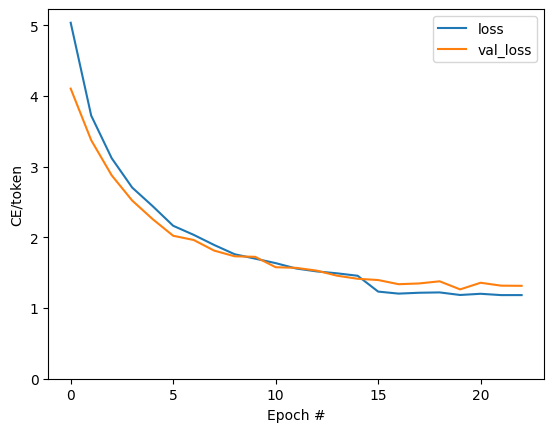

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

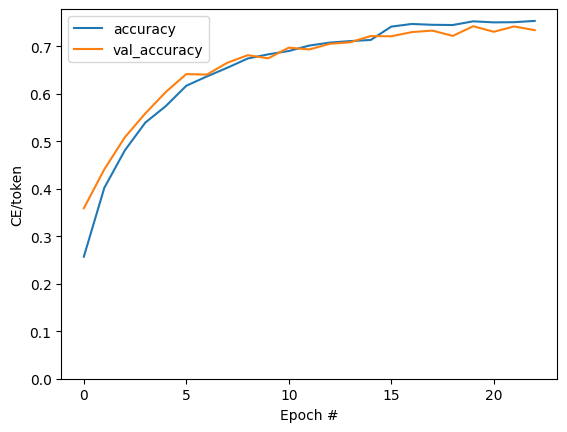

In [46]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [47]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [48]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is it still home ? '

Use that to generate the attention plot:

In [49]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

/tmpfs/tmp/ipykernel_16852/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_16852/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


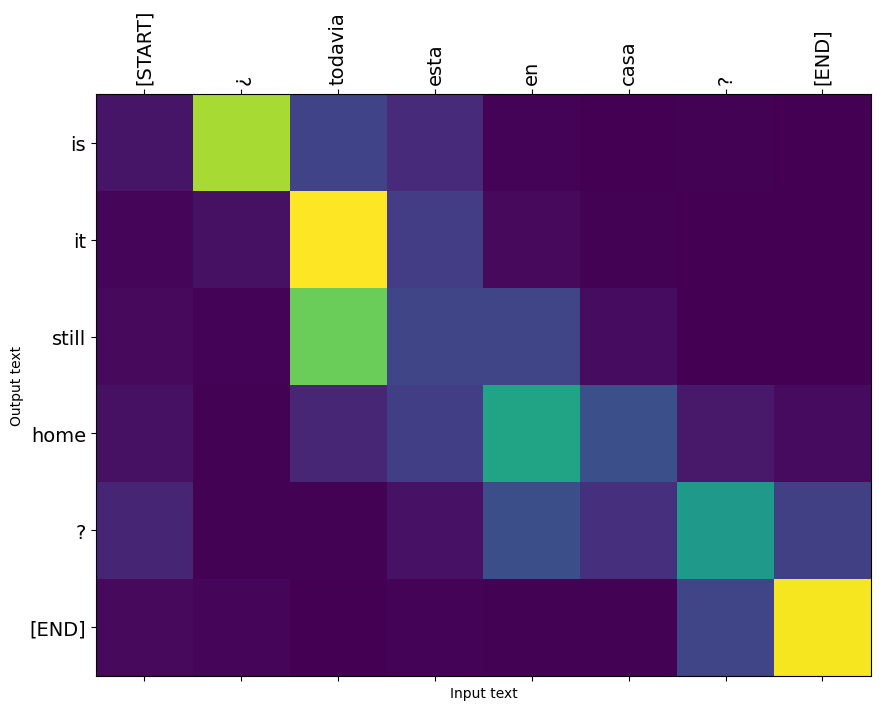

In [50]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

Translate a few more sentences and plot them:

/tmpfs/tmp/ipykernel_16852/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_16852/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 239 ms, sys: 47 ms, total: 286 ms
Wall time: 198 ms


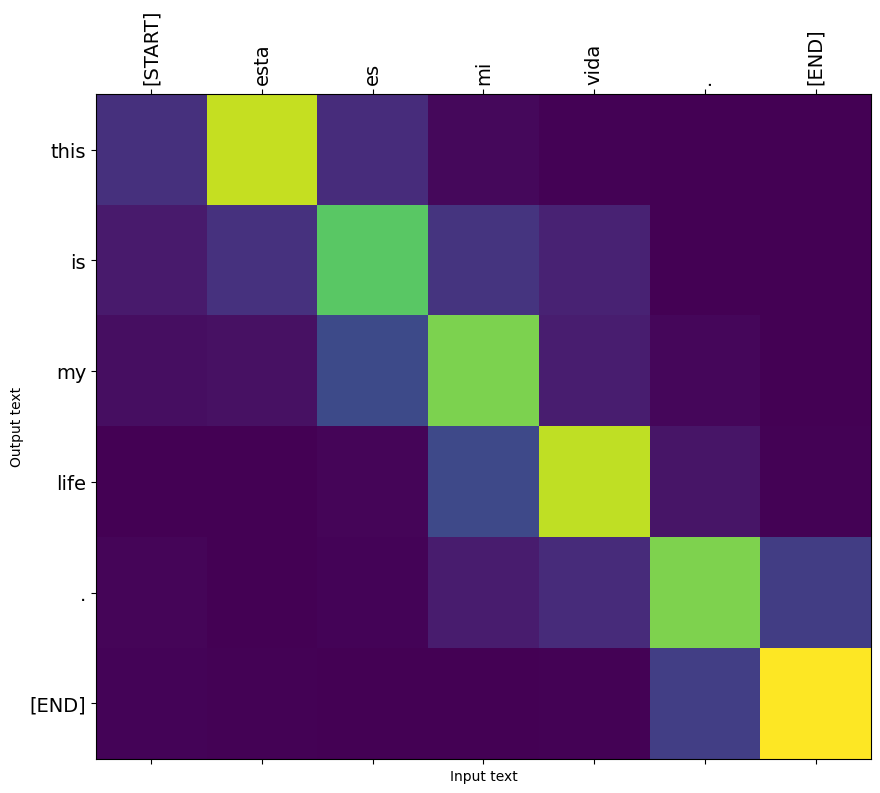

In [51]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

/tmpfs/tmp/ipykernel_16852/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_16852/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 220 ms, sys: 63.1 ms, total: 283 ms
Wall time: 196 ms


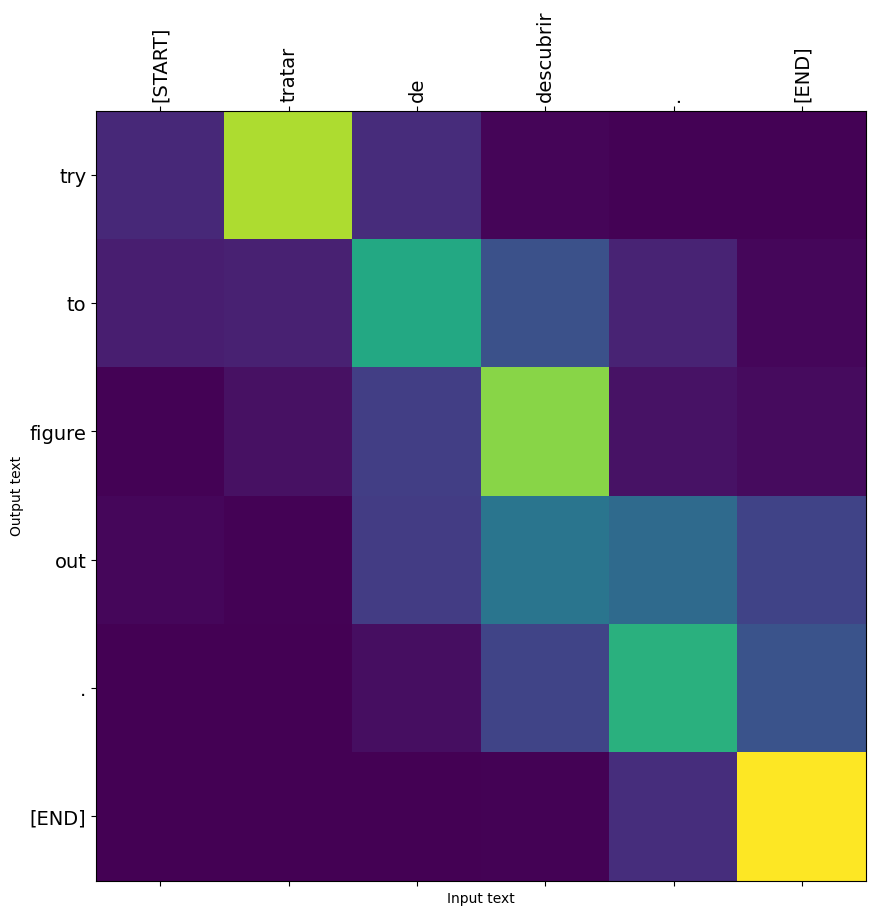

In [52]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [53]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/tmp/ipykernel_16852/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_16852/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


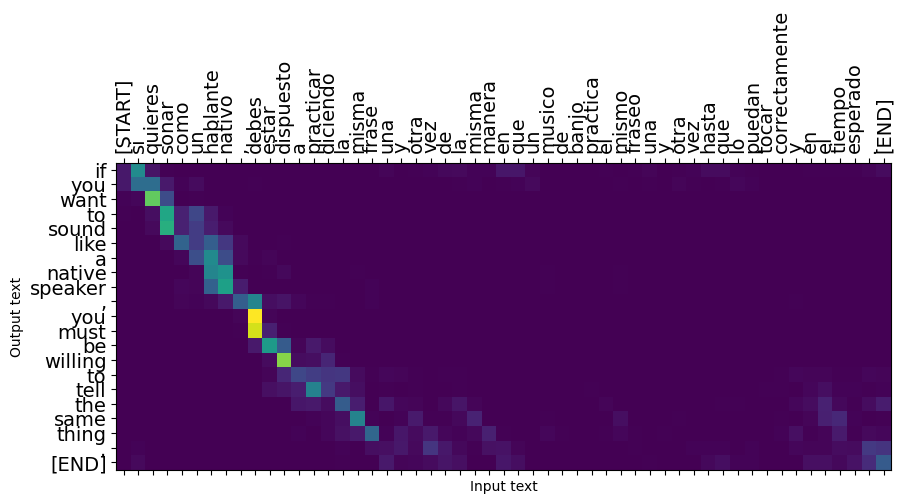

In [54]:
model.plot_attention(long_text)

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [55]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [56]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its cold here . 
this is my life . 


her room is a mess . 

CPU times: user 505 ms, sys: 20 ms, total: 525 ms
Wall time: 518 ms


In [57]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its cold here .   
this is my life .  
her room is a mess . 

CPU times: user 964 ms, sys: 9.95 ms, total: 974 ms
Wall time: 985 ms


So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [58]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [59]:
export = Export(model)

Run the `tf.function` once to compile it:

In [60]:
%%time
_ = export.translate(tf.constant(inputs))

W0000 00:00:1701951901.224441   16852 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14330101760 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1701951901.225287   16852 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "

CPU times: user 56.8 s, sys: 1.37 s, total: 58.2 s
Wall time: 57.3 s


In [61]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its cold here .                                              
this is my life .                                             
her room is a mess .                                            

CPU times: user 132 ms, sys: 18.2 ms, total: 150 ms
Wall time: 132 ms


Now that the function has been traced it can be exported using `saved_model.save`:

In [62]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


CPU times: user 1min 10s, sys: 948 ms, total: 1min 11s
Wall time: 1min 11s


In [63]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2023-12-07 12:26:26.948623: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:27.620729: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:27.719407: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:27.730802: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:28.840628: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:29.113641: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:29.297780: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:29.390506: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:29.401262: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:29.429236: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:29.512176: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:29.523005: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

2023-12-07 12:26:29.612756: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:29.889963: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:29.904132: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:30.321676: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:30.333840: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:30.952562: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:31.587636: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:31.747954: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:31.758419: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:31.828059: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:31.841421: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:31.860615: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:31.871589: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:32.015126: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:32.415935: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:32.427836: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:32.973277: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:32.987440: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:32.999725: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:33.010430: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:33.073042: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:33.449532: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:33.460910: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:33.697277: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:33.829566: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:33.840227: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:36.439691: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.451798: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.576061: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.586847: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.607916: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:36.703713: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.725119: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.776850: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:36.945446: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:36.956754: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:37.578512: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:37.589238: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:37.638069: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:37.648438: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:37.660114: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:37.811462: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:37.912472: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:37.923672: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.014409: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:38.026320: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.082647: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.094670: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:38.308973: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.321667: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:38.830232: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.841017: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.871593: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.882028: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:38.896500: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:39.096337: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.106893: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.139453: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.150113: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:39.555243: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.566061: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.577701: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.587860: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:39.604954: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:39.827448: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:40.047370: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.058536: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.076495: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.087785: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.105670: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

2023-12-07 12:26:40.437676: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.449112: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.614461: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:40.850527: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.861031: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:40.943945: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:41.359792: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:41.370255: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:41.864374: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:41.932957: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:41.944267: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:41.963262: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:41.974456: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_sh

2023-12-07 12:26:42.859014: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:42.870901: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:42.929756: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:42.941754: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:42.952280: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

2023-12-07 12:26:43.062528: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:43.177318: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:43.187645: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:43.246919: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:43.257070: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

2023-12-07 12:26:44.539314: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:44.550434: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:44.567303: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:44.658590: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:44.669101: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

2023-12-07 12:26:44.887137: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:44.897819: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:45.000661: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:45.010826: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:26:45.182639: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:45.193465: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:45.210968: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:45.365541: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:26:45.376302: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

W0000 00:00:1701952016.990642   16852 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14330101760 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1701952016.991370   16852 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "

CPU times: user 48 s, sys: 1.96 s, total: 49.9 s
Wall time: 48.6 s


In [64]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its cold here .                                              
this is my life .                                             
her room is a mess .                                            

CPU times: user 131 ms, sys: 29.1 ms, total: 160 ms
Wall time: 138 ms


#### [Optional] Use a dynamic loop

It's worth noting that this initial implementation is not optimal. It uses a python loop:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

The python loop is relatively simple but when `tf.function` converts this to a graph, it **statically unrolls** that loop. Unrolling the loop has two disadvantages:

1. It makes `max_length` copies of the loop body. So the generated graphs take longer to build, save and load.
1. You have to choose a fixed value for the `max_length`. 
1. You can't `break` from a statically unrolled loop. The `tf.function`
  version will run the full `max_length` iterations on every call.
  That's why the `break` only works with eager execution. This is
  still marginally faster than eager execution, but not as fast as it could be.


To fix these shortcomings, the `translate_dynamic` method, below, uses a tensorflow loop:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

It looks like a python loop, but when you use a tensor as the input to a `for` loop (or the condition of a `while` loop) `tf.function` converts it to a dynamic loop using operations like `tf.while_loop`. 

There's no need for a `max_length` here it's just in case the model gets stuck generating a loop like: `the united states of the united states of the united states...`.

On the down side, to accumulate tokens from this dynamic loop you can't just append them to a python `list`, you need to use a `tf.TensorArray`:

```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

This version of the code can be quite a bit more efficient:

In [65]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [66]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its cold here .   
this is my life .  
her room is a mess . 

CPU times: user 217 ms, sys: 9.29 ms, total: 226 ms
Wall time: 222 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [67]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [68]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [69]:
%%time
_ = export.translate(inputs)

W0000 00:00:1701952035.487670   16852 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14330101760 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 4.02 s, sys: 39.5 ms, total: 4.06 s
Wall time: 3.97 s


The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [70]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its cold here .   
this is my life .  
her room is a mess . 

CPU times: user 45.1 ms, sys: 4.86 ms, total: 50 ms
Wall time: 33.6 ms


So save this version as well:

In [71]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: dynamic_translator/assets


INFO:tensorflow:Assets written to: dynamic_translator/assets


CPU times: user 26.1 s, sys: 107 ms, total: 26.2 s
Wall time: 26.1 s


In [72]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2023-12-07 12:27:43.648070: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:44.408333: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:44.419266: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:45.101724: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.144001: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.154833: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.220104: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.230529: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

2023-12-07 12:27:45.530241: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.663150: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.673852: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.722373: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.732531: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_sh

2023-12-07 12:27:45.750944: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:45.761396: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:46.418836: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:46.671461: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:46.913282: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.073802: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.084615: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.105871: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.116026: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes at

2023-12-07 12:27:47.235939: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.246496: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:47.565299: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.576999: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.595454: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:47.874784: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:47.885903: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:48.164355: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:48.765149: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:48.776032: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:48.788116: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:48.799055: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


2023-12-07 12:27:48.998277: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.
2023-12-07 12:27:49.009647: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 40 outputs. Output shapes may be inaccurate.


W0000 00:00:1701952071.866548   16852 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14330101760 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 10.6 s, sys: 271 ms, total: 10.9 s
Wall time: 10.8 s


In [73]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its cold here .   
this is my life .  
her room is a mess . 

CPU times: user 34 ms, sys: 4.46 ms, total: 38.4 ms
Wall time: 25.7 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.